**Sections Overview:**

1. SETUP & CONFIGURATION
   - Everything needed before running
   - All hyperparameters in one place
   - Easy to adjust settings

2. DATA PREPARATION
   - All data-related code together
   - Text processing, dataset classes, data loading
   - Transforms and preprocessing

3. MODEL ARCHITECTURE
   - Model components
   - Transformer encoder
   - Full multimodal classifier

4. TRAINING & EVALUATION
   - Training setup (optimizer, loss)
   - Training loop
   - Test evaluation
   - Results saving

5. DEMONSTRATIONS
   - Test Set Examples
   - Custom Tests

# 1. SETUP & CONFIGURATION

### Architecture (Model B) Description

- **Image Input**: 100×100 grayscale → 224×224 RGB (ResNet-18 compatible)
- **Image Backbone**: ResNet-18 (pretrained) → 512-D image feature
- **Text Input**: Short text metadata (tokenized with subword units, e.g., BPE)
- **Text Encoder**: Transformer encoder (2–4 layers, 4–8 heads) → 512-D text embedding
- **Fusion**: Cross-attention (VQA-inspired) + Concatenate [512-D image, 512-D text] → 1024-D
  - Text encoder attends to image features (optional, configurable)
  - Final fusion: concatenation of image and enhanced text features
- **Dropout**: p=0.2–0.3 (configurable, randomly drops fused features during training)
- **Head**: Linear (1024 → 7), Softmax for probabilities
- **Loss**: Cross-Entropy

### KAGGLE setup instructions


#### Using on Kaggle:
1. Find "Configuration" and change variable "RUM_IN_KAGGLE = True"
2. Confirm directory information is correct

#### Using API:
0. Find "Configuration" and change variable "RUM_IN_KAGGLE = False"
1. Get Kaggle API key from https://www.kaggle.com/account
   Go to https://www.kaggle.com/account
    Click "Create New API Token"
    Download kaggle.json
2. Place kaggle.json in ~/.kaggle/ directory
3. Run this notebook - datasets will download automatically

### Training/Testing Instructions

Adjust parameters in "Training Configuration" and run entire notebook.




## Imports
imports used for the specific model tasks

In [1]:
# Install scikit-learn if needed
import subprocess
import sys

try:
    from sklearn.model_selection import train_test_split
except ImportError:
    print("Installing scikit-learn...")
    subprocess.check_call([sys.executable, "-m", "pip", "install", "scikit-learn"])
    from sklearn.model_selection import train_test_split
    print("scikit-learn installed successfully!")

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
import timm

import pandas as pd
import numpy as np
import random

import re
from datasets import load_dataset

import sys
import os
from tqdm.notebook import tqdm


import time
import math
from collections import Counter

# Text processing library - minimal approach
from transformers import AutoTokenizer

# train_test_split is already imported above

# Set up device for GPU/CPU usage throughout the notebook
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Check CUDA availability and GPU info
if torch.cuda.is_available():
    print(f"CUDA is available!")
    print(f"GPU count: {torch.cuda.device_count()}")
    print(f"Current GPU: {torch.cuda.current_device()}")
    print(f"GPU name: {torch.cuda.get_device_name(0)}")
    print(f"GPU memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB")
else:
    print("CUDA is not available, using CPU")


Using device: cuda:0
CUDA is available!
GPU count: 1
Current GPU: 0
GPU name: NVIDIA GeForce RTX 5060 Ti
GPU memory: 15.5 GB


## Configuration

Modify parameters here for training/testing

In [2]:
# ===== TRAINING HYPERPARAMETERS =====
NUMBER_OF_EPOCHS = 100          # Number of training epochs (lower for faster experiments)
LEARNING_RATE = 0.0001         # Learning rate for optimizer (reduced from 0.001 for more stable training)
BATCH_SIZE = 64                # Batch size (higher = faster training, uses more GPU memory)

# ===== HARDWARE / DATA LOADING =====
RUN_ON_KAGGLE = False           # See instructions above.

NUM_WORKERS = 6                 # Number of DataLoader worker processes (higher = faster loading, uses more CPU RAM)
                                # Reduce if experiencing high memory swap (try 2-4 for 16GB RAM, 1-2 for 8GB RAM)
PIN_MEMORY = True if torch.cuda.is_available() else False  # Faster CPU->GPU transfer (use True if using GPU)

# ===== EXPERIMENT ID =====
EXPERIMENT_ID = 15                # Experiment ID number - check test_results.csv to make sure it's unique

# ===== MODEL ARCHITECTURE PARAMETERS =====
DROPOUT_P = 0.2                # Dropout probability for fusion layer (regularization) - 0.5 was too high!

# ===== TRANSFORMER ARCHITECTURE =====
TRANSFORMER_NUM_LAYERS = 3     # Number of transformer encoder layers (2-4 typical)
TRANSFORMER_NHEAD = 4          # Number of attention heads (4-8 typical)

# ===== OPTIMIZER =====
OPTIMIZER_TYPE = 'AdamW'        # Optimizer type: 'Adam', 'SGD', 'AdamW'

# ===== DATA AUGMENTATION =====
USE_TRANSFORM = 'transform_b'  # Options: 'transform_a' (minimal) or 'transform_b' (with augmentation)

# ===== FUSION METHOD (VQA-Inspired) =====
USE_CROSS_ATTENTION = True    # If True, uses cross-attention fusion; If False, uses concatenation

# ===== CHECKPOINT / SAVING =====
SAVE_MODEL = True              # Toggle model saving on/off
CHECKPOINT_DIR = "checkpoints"
CHECKPOINT_NAME = f"modelB_exp{EXPERIMENT_ID:03d}.pth"  # e.g., modelB_exp014.pth

# ============================================================================
# Print configuration summary
# ============================================================================
print("=" * 70)
print("TRAINING CONFIGURATION SUMMARY")
print("=" * 70)
print(f"Training: {NUMBER_OF_EPOCHS} epochs, LR={LEARNING_RATE}, Batch={BATCH_SIZE}")
print(f"Hardware: {NUM_WORKERS} DataLoader workers, Pin Memory={PIN_MEMORY}")
print(f"Model: Dropout={DROPOUT_P}")
print(f"Transformer: {TRANSFORMER_NUM_LAYERS} layers, {TRANSFORMER_NHEAD} heads")
print(f"Optimizer: {OPTIMIZER_TYPE}")
print(f"Data Augmentation: {USE_TRANSFORM}")
print(f"Fusion: {'Cross-Attention (VQA-inspired)' if USE_CROSS_ATTENTION else 'Concatenation'}")
print(f"Checkpointing: SAVE_MODEL={SAVE_MODEL}, Dir={CHECKPOINT_DIR}, Name={CHECKPOINT_NAME}")
print("=" * 70)


TRAINING CONFIGURATION SUMMARY
Training: 100 epochs, LR=0.0001, Batch=64
Hardware: 6 DataLoader workers, Pin Memory=True
Model: Dropout=0.2
Transformer: 3 layers, 4 heads
Optimizer: AdamW
Data Augmentation: transform_b
Fusion: Cross-Attention (VQA-inspired)
Checkpointing: SAVE_MODEL=True, Dir=checkpoints, Name=modelB_exp015.pth


# 2. DATA PREPARATION

### Run in Kaggle Toggle

In [3]:
running_on_kaggle = RUN_ON_KAGGLE
if(running_on_kaggle):
    print("Running On Kaggle")
    
    #Variable set up
    # Image Dataset
    str_image_data_dir = "/kaggle/input/balanced-raf-db-dataset-7575-grayscale"

    # Text Dataset
    str_text_data_dir = "/kaggle/input/emotions-dataset/emotions.csv"
    complete_csv = pd.read_csv(str_text_data_dir)
    
else:
    print("Running On Something Other Than Kaggle")
    #Imports Needed
    import kaggle
    import kagglehub
    from kagglehub import KaggleDatasetAdapter

    #Variable set up
    # Image Dataset
    str_image_data_dir = kagglehub.dataset_download("dollyprajapati182/balanced-raf-db-dataset-7575-grayscale")

    # Text Dataset
    str_text_data_dir = "bhavikjikadara/emotions-dataset"

    # Download the dataset first
    dataset_path = kagglehub.dataset_download(str_text_data_dir)
    print("Dataset downloaded to:", dataset_path)

    # Load the CSV file from the downloaded dataset
    import os
    csv_files = [f for f in os.listdir(dataset_path) if f.endswith('.csv')]
    if csv_files:
        csv_path = os.path.join(dataset_path, csv_files[0])
        complete_csv = pd.read_csv(csv_path)

print("Path to dataset files:", str_image_data_dir)
print(complete_csv)

Running On Something Other Than Kaggle
Dataset downloaded to: /home/amherscher/.cache/kagglehub/datasets/bhavikjikadara/emotions-dataset/versions/1
Path to dataset files: /home/amherscher/.cache/kagglehub/datasets/dollyprajapati182/balanced-raf-db-dataset-7575-grayscale/versions/1
                                                     text  label
0           i just feel really helpless and heavy hearted      4
1       ive enjoyed being able to slouch about relax a...      0
2       i gave up my internship with the dmrg and am f...      4
3                              i dont know i feel so lost      0
4       i am a kindergarten teacher and i am thoroughl...      4
...                                                   ...    ...
416804  i feel like telling these horny devils to find...      2
416805  i began to realize that when i was feeling agi...      3
416806  i feel very curious be why previous early dawn...      5
416807  i feel that becuase of the tyranical nature of...      3
416

### Text Processing Functions

In [4]:
# Text Processing using transformers library (minimal code approach)
# Initialize tokenizer - uses BPE tokenization automatically

tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

def tokenize_text(text, max_length=None):
    """Tokenize text using pre-trained tokenizer - minimal code
    Uses MAX_TEXT_LENGTH from config if max_length is not provided"""
    if max_length is None:
        # Try to use config value, fallback to 15 if config not yet defined
        try:
            max_length = MAX_TEXT_LENGTH
        except NameError:
            max_length = 15  # Default fallback
    encoded = tokenizer(
        text,
        max_length=max_length,
        padding='max_length',
        truncation=True,
        return_tensors='pt'
    )
    return encoded['input_ids'].squeeze(0)  # Return token IDs as tensor
    
def get_vocab_size():
    """Get vocabulary size from tokenizer"""
    return tokenizer.vocab_size


### Dictionaries


In [5]:
#Label Dictionary
# class number : class as string
label_dict ={
    0:"Angry",
    1:"Disgust",
    2:"Fear",
    3:"Happy",
    4:"Neutral",
    5:"Sad",
    6:"Surprise"
}

In [6]:
#Translation Dictionary
# Text Class Number : Images Class Number
# So you can put in the text class number and get out the version of the number as the images dataset uses.
translation_dictionary = {
    0:5, #Sadness -> Sad
    1:3, #Joy -> Happy
    2:3, #Love -> Happy
    3:0, #Anger -> Angry
    4:2, #Fear -> Fear
    5:6  #Surprise -> Surprise
}

In [7]:
# Fixed model architecture constants (required for model initialization)
NUM_CLASSES = 7                        # Number of emotion classes
TRANSFORMER_D_MODEL = 512              # Transformer model dimension
TRANSFORMER_DROPOUT = 0.1              # Transformer internal dropout
TRANSFORMER_DIM_FEEDFORWARD = 2048     # Transformer feedforward dimension


### MultiModal Dataset Class

In [8]:
class OurMultiModalDataSet(Dataset):
    """Multimodal dataset combining images and text for Architecture B"""
    def __init__(self, data_directory, text_dataframe, transform=None, max_text_length=None):
        # Use config value if not provided
        max_text_length = max_text_length if max_text_length is not None else MAX_TEXT_LENGTH
        self.data_image = ImageFolder(data_directory, transform=transform)
        self.text_dataframe = text_dataframe
        self.max_text_length = max_text_length
        
        # Ensure text data matches image data length
        # For now, we'll sample text randomly or use a mapping strategy
        # In production, you'd want proper image-text pairing
        
    def __len__(self):
        return len(self.data_image)
    
    def __getitem__(self, at_index):
        # Get image and label
        image, label = self.data_image[at_index]
        
        # Get corresponding text - sample from text data with matching label
        # If no exact match, use random text with same label
        matching_texts = self.text_dataframe[self.text_dataframe['label'] == label]['text']
        if len(matching_texts) > 0:
            text = matching_texts.sample(n=1).iloc[0]
        else:
            # Fallback: use any text
            text = self.text_dataframe.sample(n=1).iloc[0]['text']
        
        # Tokenize text
        text_tokens = tokenize_text(text, max_length=self.max_text_length)
        
        return image, text_tokens, label

    @property
    def classes(self):
        return self.data_image.classes
#END CLASS

### Text data loading
Load the CSV and split it into sub-sections

In [9]:
#Read CSV into a data-frame
print("Preview of the CSV contents:")
print(complete_csv)
print("-- -- -- -- -- -- --")

#Fix class labeling missmatch
complete_csv['label'] = complete_csv['label'].replace(translation_dictionary)
print("Preview of altered CSV contents:")
print(complete_csv)
print("-- -- -- -- -- -- --")

#Split CSV into segments for Testing, Training, and Validation
from sklearn.model_selection import train_test_split

# Fixed data split values
TRAIN_TEST_SPLIT = 0.3  # 70% train, 30% val+test
VAL_TEST_SPLIT = 0.5    # 15% val, 15% test
RANDOM_STATE = 42       # Random seed for reproducibility

# Split: Uses config values (default: 70% train, 15% val, 15% test)
train_text, temp_text, train_labels, temp_labels = train_test_split(
    complete_csv['text'], complete_csv['label'], 
    test_size=TRAIN_TEST_SPLIT, random_state=RANDOM_STATE, stratify=complete_csv['label']
)
val_text, test_text, val_labels, test_labels = train_test_split(
    temp_text, temp_labels,
    test_size=VAL_TEST_SPLIT, random_state=RANDOM_STATE, stratify=temp_labels
)

# Create dataframes for each split
train_text_df = pd.DataFrame({'text': train_text, 'label': train_labels})
val_text_df = pd.DataFrame({'text': val_text, 'label': val_labels})
test_text_df = pd.DataFrame({'text': test_text, 'label': test_labels})

print(f"Train: {len(train_text_df)}, Val: {len(val_text_df)}, Test: {len(test_text_df)}")


Preview of the CSV contents:
                                                     text  label
0           i just feel really helpless and heavy hearted      4
1       ive enjoyed being able to slouch about relax a...      0
2       i gave up my internship with the dmrg and am f...      4
3                              i dont know i feel so lost      0
4       i am a kindergarten teacher and i am thoroughl...      4
...                                                   ...    ...
416804  i feel like telling these horny devils to find...      2
416805  i began to realize that when i was feeling agi...      3
416806  i feel very curious be why previous early dawn...      5
416807  i feel that becuase of the tyranical nature of...      3
416808  i think that after i had spent some time inves...      5

[416809 rows x 2 columns]
-- -- -- -- -- -- --
Preview of altered CSV contents:
                                                     text  label
0           i just feel really helpless and h

### Datasets/Transforms

In [10]:
# Fixed data processing values
MAX_TEXT_LENGTH = 15  # Maximum length for text tokenization

# Strings of data directories
str_data_dir_train = str_image_data_dir + '/train'
str_data_dir_valid = str_image_data_dir + '/val'
str_data_dir_test  = str_image_data_dir + '/test'

#Transform
# A- this is meant for the balanced grey-scale RAF data set
# FIXED: Added Resize and proper preprocessing for ResNet
transform_a = transforms.Compose([
    transforms.Resize((224, 224)),  # ResNet requires 224x224
    # transforms.Grayscale(num_output_channels=3),  # UNCOMMENT if images are grayscale
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ImageNet normalization
])

# B- this is meant for the RAF data set
transform_b = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    # transforms.Grayscale(num_output_channels=3),  # UNCOMMENT if images are grayscale
    transforms.ColorJitter(brightness=0.1, contrast=0.1),   
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Select transform based on config (uses config value)
transform_used = transform_a if USE_TRANSFORM == 'transform_a' else transform_b

# Batch size from config
batch_size = BATCH_SIZE

# Create Multimodal Datasets for Architecture B (uses config values)
dataset_mm_train = OurMultiModalDataSet(str_data_dir_train, train_text_df, transform=transform_used, max_text_length=MAX_TEXT_LENGTH)
dataset_mm_valid = OurMultiModalDataSet(str_data_dir_valid, val_text_df, transform=transform_used, max_text_length=MAX_TEXT_LENGTH)
dataset_mm_test = OurMultiModalDataSet(str_data_dir_test, test_text_df, transform=transform_used, max_text_length=MAX_TEXT_LENGTH)

# Create multimodal data loaders
def collate_multimodal(batch):
    """Custom collate function for multimodal data"""
    images = torch.stack([item[0] for item in batch])
    text_tokens = torch.stack([item[1] for item in batch])
    labels = torch.tensor([item[2] for item in batch], dtype=torch.long)
    return images, text_tokens, labels

# DataLoader optimization for GPU speed
# num_workers: Parallel data loading (uses NUM_WORKERS from Configuration section)
# pin_memory: Faster CPU->GPU transfer (uses PIN_MEMORY from Configuration section)
# persistent_workers: Keep workers alive between epochs (faster, uses more RAM)
# Note: NUM_WORKERS and PIN_MEMORY are defined in the Configuration section above

loader_mm_train = DataLoader(
    dataset_mm_train, 
    batch_size=batch_size, 
    shuffle=True, 
    collate_fn=collate_multimodal,
    num_workers=NUM_WORKERS,
    pin_memory=PIN_MEMORY,
    persistent_workers=True if NUM_WORKERS > 0 else False
)
loader_mm_valid = DataLoader(
    dataset_mm_valid, 
    batch_size=batch_size, 
    shuffle=False, 
    collate_fn=collate_multimodal,
    num_workers=NUM_WORKERS,
    pin_memory=PIN_MEMORY,
    persistent_workers=True if NUM_WORKERS > 0 else False
)
loader_mm_test = DataLoader(
    dataset_mm_test, 
    batch_size=batch_size, 
    shuffle=False, 
    collate_fn=collate_multimodal,
    num_workers=NUM_WORKERS,
    pin_memory=PIN_MEMORY,
    persistent_workers=True if NUM_WORKERS > 0 else False
)

print(f"Multimodal datasets created:")
print(f"Train: {len(dataset_mm_train)}, Val: {len(dataset_mm_valid)}, Test: {len(dataset_mm_test)}")


Multimodal datasets created:
Train: 30023, Val: 7504, Test: 4165


# 3. MODEL ARCHITECTURE

## Transformer Encoder


In [11]:
# Transformer Encoder for Text Processing (Architecture B)
# Enhanced with cross-attention to image features (VQA-inspired)
# This must be defined before MultiModalEmotionClassifierB
class TransformerEncoder(nn.Module):
    def __init__(self, vocab_size, d_model=None, nhead=None, num_layers=None, dropout=None, dim_feedforward=None, use_cross_attention=None):
        super().__init__()
        # Use config values if not provided
        d_model = d_model if d_model is not None else TRANSFORMER_D_MODEL
        nhead = nhead if nhead is not None else TRANSFORMER_NHEAD
        num_layers = num_layers if num_layers is not None else TRANSFORMER_NUM_LAYERS
        dropout = dropout if dropout is not None else TRANSFORMER_DROPOUT
        dim_feedforward = dim_feedforward if dim_feedforward is not None else TRANSFORMER_DIM_FEEDFORWARD
        use_cross_attention = use_cross_attention if use_cross_attention is not None else USE_CROSS_ATTENTION
        
        self.d_model = d_model
        self.use_cross_attention = use_cross_attention
        
        # Embedding layer
        self.embedding = nn.Embedding(vocab_size, d_model, padding_idx=0)
        self.pos_encoding = self._create_positional_encoding(d_model)
        
        # Transformer encoder (text self-attention)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        
        # Cross-attention to image features (VQA-inspired, novel for emotion classification)
        if use_cross_attention:
            # Text attends to image features (text queries, image keys/values)
            self.cross_attention = nn.MultiheadAttention(
                embed_dim=d_model,
                num_heads=nhead,
                dropout=dropout,
                batch_first=True
            )
            self.cross_norm = nn.LayerNorm(d_model)
            self.cross_ffn = nn.Sequential(
                nn.Linear(d_model, dim_feedforward),
                nn.GELU(),
                nn.Dropout(dropout),
                nn.Linear(dim_feedforward, d_model)
            )
        
        # Output projection to 512-D
        self.output_proj = nn.Linear(d_model, 512)
        
    def _create_positional_encoding(self, d_model, max_len=100):
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        return pe.unsqueeze(0)
    
    def forward(self, text_tokens, image_features=None):
        """
        Args:
            text_tokens: [batch_size, seq_len] - text token IDs
            image_features: [batch_size, 512] - optional image features for cross-attention
        Returns:
            text_features: [batch_size, 512] - text features (with cross-attention if enabled)
        """
        # Get sequence length
        seq_len = text_tokens.size(1)
        
        # Embedding + positional encoding
        embedded = self.embedding(text_tokens) * math.sqrt(self.d_model)
        embedded = embedded + self.pos_encoding[:, :seq_len, :].to(text_tokens.device)
        
        # Create attention mask for padding tokens
        attention_mask = (text_tokens != 0).float()
        
        # Transformer encoding (text self-attention)
        transformer_output = self.transformer(embedded, src_key_padding_mask=attention_mask == 0)
        
        # Cross-attention to image features (VQA-inspired, novel for emotion classification)
        if self.use_cross_attention and image_features is not None:
            # Reshape image features to [batch_size, 1, d_model] for attention
            img_tokens = image_features.unsqueeze(1)  # [B, 1, 512]
            
            # Text attends to image: text queries attend to image keys/values
            attended, _ = self.cross_attention(
                query=transformer_output,  # text features as queries
                key=img_tokens,            # image features as keys
                value=img_tokens           # image features as values
            )
            
            # Residual connection and normalization
            transformer_output = self.cross_norm(transformer_output + attended)
            
            # Feedforward
            ffn_out = self.cross_ffn(transformer_output)
            transformer_output = self.cross_norm(transformer_output + ffn_out)
        
        # Global average pooling (mean of non-padded tokens)
        mask = attention_mask.unsqueeze(-1).expand_as(transformer_output)
        masked_output = transformer_output * mask
        text_features = masked_output.sum(dim=1) / mask.sum(dim=1)
        
        # Project to 512-D
        text_features = self.output_proj(text_features)
        
        return text_features


## MultiModal Classifier

In [12]:
# Architecture B: MultiModal Emotion Classifier with Transformer
class MultiModalEmotionClassifierB(nn.Module):
    def __init__(self, num_classes=None, vocab_size=1000, dropout_p=None, use_cross_attention=None):
        super().__init__()
        # Use config values if not provided
        num_classes = num_classes if num_classes is not None else NUM_CLASSES
        dropout_p = dropout_p if dropout_p is not None else DROPOUT_P
        use_cross_attention = use_cross_attention if use_cross_attention is not None else USE_CROSS_ATTENTION
        
        self.use_cross_attention = use_cross_attention
        
        enet_out_size = 512
        
        #Image Model (Resnet18)
        self.base_image_model = torchvision.models.resnet18(pretrained=True) #Set base model
        self.features = nn.Sequential(*list(self.base_image_model.children())[:-1])

        #Text Model (Transformer) - Architecture B (uses config values)
        # Enhanced with cross-attention to image features if enabled
        self.text_encoder = TransformerEncoder(
            vocab_size=vocab_size,
            use_cross_attention=use_cross_attention
        )

        #Dropout Method (uses config value)
        self.dropout = nn.Dropout(p=dropout_p)
        
        # Updated classifier for 1024-D input (512 image + 512 text)
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(1024, num_classes)  # Changed from 512 to 1024
        )

    def forward(self, images, text_tokens):
        # Image Processing
        image_features = self.features(images).view(images.size(0), -1)

        # Text Processing with Transformer
        # If cross-attention enabled, text encoder attends to image features (VQA-inspired)
        if self.use_cross_attention:
            text_features = self.text_encoder(text_tokens, image_features=image_features)
            # With cross-attention, text already incorporates image info, so we can use just text
            # Or combine both for richer representation
            fused_features = torch.cat([image_features, text_features], dim=1)
        else:
            text_features = self.text_encoder(text_tokens)
            # Original concatenation fusion
            fused_features = torch.cat([image_features, text_features], dim=1)

        # Dropout, randomly select p% of features to drop
        fused_features = self.dropout(fused_features)
        
        # Classify
        logits = self.classifier(fused_features)
        probabilities = torch.softmax(logits, dim=1)
        return logits, probabilities
#END CLASS

#Create the Architecture B model
# Use tokenizer's vocab size and config values
model_multi_b = MultiModalEmotionClassifierB(
    num_classes=NUM_CLASSES, 
    vocab_size=get_vocab_size(), 
    dropout_p=DROPOUT_P,
    use_cross_attention=USE_CROSS_ATTENTION
)

# Freeze ResNet (use pretrained weights only - faster training, ~3x speedup)
# Only trains text encoder + fusion layers (~11M params vs ~37M if fine-tuned)
for param in model_multi_b.features.parameters():
    param.requires_grad = False

model_multi_b.to(device)

#this is just done to show a snippet of the models layout.
print("Architecture B - Transformer-based Multimodal Model:")
print(str(model_multi_b)[:500])


/home/data/Purdue/CSCI495/phase4/final_phase4_code/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/data/Purdue/CSCI495/phase4/final_phase4_code/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Architecture B - Transformer-based Multimodal Model:
MultiModalEmotionClassifierB(
  (base_image_model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=F


# 4. TRAINING & EVALUATION


### Experiment Tracking and Results Export (THIS SECTION CAN BE IGNORED FOR NOW)


In [13]:
# Experiment Tracking System
# This module tracks experiments, calculates metrics, and exports results to CSV

from sklearn.metrics import f1_score, classification_report, confusion_matrix
import csv
from datetime import datetime
import os

class ExperimentTracker:
    """Tracks experiment configurations and results for easy comparison and CSV export"""
    
    def __init__(self, csv_file='experiment_results.csv'):
        self.experiments = []
        self.csv_file = csv_file
        self.fieldnames = ['ID', 'Cross-Attn', 'ResNet train', 'Dropout', 'LR', 
                          'Val Acc', 'Macro-F1', 'Params (M)', 'Notes']
        
    def add_experiment(self, exp_id, cross_attn, resnet_train, dropout, lr, 
                      val_acc, macro_f1, params_m, notes=''):
        """Add an experiment result"""
        experiment = {
            'ID': exp_id,
            'Cross-Attn': 'On' if cross_attn else 'Off',
            'ResNet train': resnet_train,  # 'Frozen' or 'Fine-tune'
            'Dropout': dropout,
            'LR': f'{lr:.0e}',  # Scientific notation
            'Val Acc': f'{val_acc:.2f}%' if val_acc is not None else '',
            'Macro-F1': f'{macro_f1:.4f}' if macro_f1 is not None else '',
            'Params (M)': f'{params_m:.2f}' if params_m is not None else '',
            'Notes': notes
        }
        self.experiments.append(experiment)
        return experiment
    
    def calculate_f1_macro(self, y_true, y_pred):
        """Calculate macro-averaged F1 score"""
        return f1_score(y_true, y_pred, average='macro')
    
    def print_table(self):
        """Print a formatted table of all experiments"""
        if not self.experiments:
            print("No experiments recorded yet.")
            return
        
        # Calculate column widths
        col_widths = {field: len(field) for field in self.fieldnames}
        for exp in self.experiments:
            for field in self.fieldnames:
                col_widths[field] = max(col_widths[field], len(str(exp.get(field, ''))))
        
        # Print header
        header = ' | '.join(field.ljust(col_widths[field]) for field in self.fieldnames)
        print('=' * len(header))
        print(header)
        print('=' * len(header))
        
        # Print rows
        for exp in self.experiments:
            row = ' | '.join(str(exp.get(field, '')).ljust(col_widths[field]) 
                            for field in self.fieldnames)
            print(row)
        
        print('=' * len(header))
        print(f"\nTotal experiments: {len(self.experiments)}")
    
    def export_to_csv(self):
        """Export experiments to CSV file"""
        file_exists = os.path.exists(self.csv_file)
        
        with open(self.csv_file, 'a', newline='') as csvfile:
            writer = csv.DictWriter(csvfile, fieldnames=self.fieldnames)
            
            # Write header if file is new
            if not file_exists:
                writer.writeheader()
            
            # Write all experiments
            for exp in self.experiments:
                writer.writerow(exp)
        
        print(f"Results exported to {self.csv_file}")
    
    def clear(self):
        """Clear all experiments (useful for fresh start)"""
        self.experiments = []

# Initialize global tracker
tracker = ExperimentTracker()


In [14]:
# Helper function to check if ResNet is frozen
# Note: ResNet is always frozen (pretrained only) for faster training
def is_resnet_frozen(model):
    """Check if ResNet backbone is frozen (not training) - always returns 'Frozen'"""
    return 'Frozen'  # ResNet is always frozen (pretrained only)

# Helper function to evaluate model and calculate F1
def evaluate_model_with_f1(model, data_loader, device, num_classes=7):
    """Evaluate model and return accuracy and macro-F1 score"""
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for images, text_tokens, labels in data_loader:
            images = images.to(device)
            text_tokens = text_tokens.to(device)
            labels = labels.to(device)
            
            logits, probabilities = model(images, text_tokens)
            _, predicted = logits.max(1)
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # Calculate accuracy
    accuracy = 100.0 * sum(p == l for p, l in zip(all_preds, all_labels)) / len(all_labels)
    
    # Calculate macro-F1
    macro_f1 = tracker.calculate_f1_macro(all_labels, all_preds)
    
    return accuracy, macro_f1

# Helper function to count model parameters
def count_parameters(model):
    """Count total number of trainable parameters in millions"""
    return sum(p.numel() for p in model.parameters() if p.requires_grad) / 1e6


## Training & Evaluation - Instructions

**IMPORTANT: Choose ONE of the following options:**

### Option A: Train a New Model
- Run the **"Training Setup"** cell (below)
- Run the **"Training Loop"** cell to train from scratch
- The model will be saved automatically after training (if `SAVE_MODEL=True`)

### Option B: Load a Saved Checkpoint
- Skip the "Training Setup" and "Training Loop" cells
- Go directly to the **"Load Saved Model"** section (later in notebook)
- Set `EXPERIMENT_ID` to match the checkpoint you want to load
- Run the "Load Saved Model" cell

**Note:** Do NOT run both Training Loop and Load Saved Model - choose one based on whether you want to train a new model or use an existing checkpoint.


## Training Setup

In [15]:
# Training Setup for Architecture B
# Loss Function
criterion = nn.CrossEntropyLoss()

# Fixed optimizer parameters
OPTIMIZER_WEIGHT_DECAY = 0.0001  # Weight decay (L2 regularization) - small regularization helps
OPTIMIZER_MOMENTUM = 0.9       # Momentum (only used for SGD)

# Optimizer for multimodal model (uses config values)
if OPTIMIZER_TYPE == 'Adam':
    optimizer_mm = optim.Adam(model_multi_b.parameters(), lr=LEARNING_RATE, weight_decay=OPTIMIZER_WEIGHT_DECAY)
elif OPTIMIZER_TYPE == 'SGD':
    optimizer_mm = optim.SGD(model_multi_b.parameters(), lr=LEARNING_RATE, momentum=OPTIMIZER_MOMENTUM, weight_decay=OPTIMIZER_WEIGHT_DECAY)
elif OPTIMIZER_TYPE == 'AdamW':
    optimizer_mm = optim.AdamW(model_multi_b.parameters(), lr=LEARNING_RATE, weight_decay=OPTIMIZER_WEIGHT_DECAY)
else:
    raise ValueError(f"Unknown optimizer type: {OPTIMIZER_TYPE}. Use 'Adam', 'SGD', or 'AdamW'")

# Learning rate scheduler - reduces LR when validation loss plateaus
# This helps fine-tune and improve accuracy
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer_mm, 
    mode='min', 
    factor=0.5,  # Reduce LR by half
    patience=3   # Wait 3 epochs without improvement
    # Note: 'verbose' parameter removed - not supported in all PyTorch versions
)

# Training parameters (uses config value)
number_of_epochs = NUMBER_OF_EPOCHS
training_losses = []
validation_losses = []
training_accuracies = []
validation_accuracies = []

# Move model to device
model_multi_b.to(device)
print(f"Architecture B model ready for training on {device}")
print(f"Model parameters: {sum(p.numel() for p in model_multi_b.parameters()):,}")


Architecture B model ready for training on cuda:0
Model parameters: 40,195,119


## Training Loop (Option A: Train New Model)

**⚠️ Only run this section if you want to train a new model from scratch.**

If you want to load a saved checkpoint instead, **skip this entire section** and go to **"Load Saved Model (Option B)"** later in the notebook.

In [16]:
# Training Loop for Architecture B

print(f"Starting training for {number_of_epochs} epochs...")
print(f"Training batches: {len(loader_mm_train)}")
print(f"Validation batches: {len(loader_mm_valid)}")

total_start_time = time.time()

for epoch in range(number_of_epochs):
    epoch_start_time = time.time()
    print(f"\n=== EPOCH {epoch+1}/{number_of_epochs} ===")
    
    # Training Phase
    model_multi_b.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for images, text_tokens, labels in tqdm(loader_mm_train, desc=f'Epoch {epoch+1}/{number_of_epochs} - Training'):
        # Move to device
        images = images.to(device)
        text_tokens = text_tokens.to(device)
        labels = labels.to(device)
        
        # Forward pass
        optimizer_mm.zero_grad()
        logits, probabilities = model_multi_b(images, text_tokens)
        loss = criterion(logits, labels)
        
        # Backward pass
        loss.backward()
        optimizer_mm.step()
        
        # Metrics
        running_loss += loss.item() * labels.size(0)
        _, predicted = logits.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
    
    # Training metrics
    train_loss = running_loss / len(loader_mm_train.dataset)
    train_acc = 100. * correct / total
    training_losses.append(train_loss)
    training_accuracies.append(train_acc)
    
    # Validation Phase
    model_multi_b.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, text_tokens, labels in tqdm(loader_mm_valid, desc=f'Epoch {epoch+1}/{number_of_epochs} - Validation'):
            # Move to device
            images = images.to(device)
            text_tokens = text_tokens.to(device)
            labels = labels.to(device)
            
            # Forward pass
            logits, probabilities = model_multi_b(images, text_tokens)
            loss = criterion(logits, labels)
            
            # Metrics
            running_loss += loss.item() * labels.size(0)
            _, predicted = logits.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    
    # Validation metrics
    valid_loss = running_loss / len(loader_mm_valid.dataset)
    valid_acc = 100. * correct / total
    validation_losses.append(valid_loss)
    validation_accuracies.append(valid_acc)
    
    # Learning rate scheduling - reduce LR if validation loss plateaus
    scheduler.step(valid_loss)
    current_lr = optimizer_mm.param_groups[0]['lr']
    
    # Epoch summary
    epoch_time = time.time() - epoch_start_time
    total_time = time.time() - total_start_time
    
    print(f"Epoch {epoch+1}/{number_of_epochs} Summary:")
    print(f"  Train - Loss: {train_loss:.4f}, Acc: {train_acc:.2f}%")
    print(f"  Valid - Loss: {valid_loss:.4f}, Acc: {valid_acc:.2f}%")
    print(f"  LR: {current_lr:.6f}")
    print(f"  Time: {epoch_time:.2f}s | Total: {total_time:.2f}s")

# Final summary
total_training_time = time.time() - total_start_time
print(f"\n Training completed!")
print(f"Total training time: {total_training_time:.2f}s ({total_training_time/60:.1f} minutes)")
print(f"Best validation accuracy: {max(validation_accuracies):.2f}%")
print(f"Final validation accuracy: {validation_accuracies[-1]:.2f}%")
print(f"Final training accuracy: {training_accuracies[-1]:.2f}%")

# Check if still improving - helps decide if more epochs are worth it
if len(validation_accuracies) >= 3:
    recent_improvement = validation_accuracies[-1] - validation_accuracies[-3]
    train_val_gap = training_accuracies[-1] - validation_accuracies[-1] if training_accuracies else 0
    
    if recent_improvement > 0.5:
        print(f"\n Still improving! Recent gain: +{recent_improvement:.2f}%")
        print("   → Continue training - more epochs likely to help")
    elif recent_improvement < -1.0:
        # Significant decline - likely overfitting
        print(f"\n  Validation accuracy declining significantly: {recent_improvement:.2f}%")
        print(f"   → Training acc: {training_accuracies[-1]:.2f}%, Val acc: {validation_accuracies[-1]:.2f}%")
        print(f"   → Gap: {train_val_gap:.2f}% (large gap = overfitting)")
        print("   → STOP: Model is overfitting. More epochs will make it worse.")
        print("   → Solutions: Lower LR, increase dropout, or use best checkpoint")
    elif recent_improvement < -0.5:
        # Small decline - could be temporary or early overfitting
        print(f"\n  Validation accuracy declining: {recent_improvement:.2f}%")
        print(f"   → Training acc: {training_accuracies[-1]:.2f}%, Val acc: {validation_accuracies[-1]:.2f}%")
        print(f"   → Gap: {train_val_gap:.2f}%")
        if train_val_gap > 5.0:
            print("   → Large train-val gap suggests overfitting starting")
            print("   → Consider stopping or reducing learning rate")
        else:
            print("   → Could be temporary (LR reduction, noise). Monitor next 2-3 epochs.")
    else:
        print(f"\n➡️  Plateauing (change: {recent_improvement:.2f}%)")
        print("   → Validation accuracy stable. May need:")
        print("     - More epochs (if still room to improve)")
        print("     - Lower learning rate (if LR hasn't been reduced)")


Starting training for 100 epochs...
Training batches: 470
Validation batches: 118

=== EPOCH 1/100 ===


Epoch 1/100 - Training:   0%|          | 0/470 [00:00<?, ?it/s]

Epoch 1/100 - Validation:   0%|          | 0/118 [00:00<?, ?it/s]

/home/data/Purdue/CSCI495/phase4/final_phase4_code/.venv/lib/python3.12/site-packages/torch/nn/modules/transformer.py:515: UserWarning: The PyTorch API of nested tensors is in prototype stage and will change in the near future. We recommend specifying layout=torch.jagged when constructing a nested tensor, as this layout receives active development, has better operator coverage, and works with torch.compile. (Triggered internally at /pytorch/aten/src/ATen/NestedTensorImpl.cpp:178.)
  output = torch._nested_tensor_from_mask(


Epoch 1/100 Summary:
  Train - Loss: 1.4520, Acc: 44.25%
  Valid - Loss: 1.2032, Acc: 55.86%
  LR: 0.000100
  Time: 44.06s | Total: 44.06s

=== EPOCH 2/100 ===


Epoch 2/100 - Training:   0%|          | 0/470 [00:00<?, ?it/s]

Epoch 2/100 - Validation:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 2/100 Summary:
  Train - Loss: 1.0768, Acc: 59.75%
  Valid - Loss: 0.9893, Acc: 62.59%
  LR: 0.000100
  Time: 38.97s | Total: 83.03s

=== EPOCH 3/100 ===


Epoch 3/100 - Training:   0%|          | 0/470 [00:00<?, ?it/s]

Epoch 3/100 - Validation:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 3/100 Summary:
  Train - Loss: 0.9975, Acc: 62.73%
  Valid - Loss: 0.9284, Acc: 64.10%
  LR: 0.000100
  Time: 39.43s | Total: 122.47s

=== EPOCH 4/100 ===


Epoch 4/100 - Training:   0%|          | 0/470 [00:00<?, ?it/s]

Epoch 4/100 - Validation:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 4/100 Summary:
  Train - Loss: 0.9394, Acc: 64.22%
  Valid - Loss: 0.8987, Acc: 65.76%
  LR: 0.000100
  Time: 40.17s | Total: 162.64s

=== EPOCH 5/100 ===


Epoch 5/100 - Training:   0%|          | 0/470 [00:00<?, ?it/s]

Epoch 5/100 - Validation:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 5/100 Summary:
  Train - Loss: 0.9023, Acc: 65.83%
  Valid - Loss: 0.8816, Acc: 65.59%
  LR: 0.000100
  Time: 41.25s | Total: 203.89s

=== EPOCH 6/100 ===


Epoch 6/100 - Training:   0%|          | 0/470 [00:00<?, ?it/s]

Epoch 6/100 - Validation:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 6/100 Summary:
  Train - Loss: 0.8850, Acc: 65.84%
  Valid - Loss: 0.8713, Acc: 65.98%
  LR: 0.000100
  Time: 41.66s | Total: 245.55s

=== EPOCH 7/100 ===


Epoch 7/100 - Training:   0%|          | 0/470 [00:00<?, ?it/s]

Epoch 7/100 - Validation:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 7/100 Summary:
  Train - Loss: 0.8619, Acc: 66.93%
  Valid - Loss: 0.8919, Acc: 65.96%
  LR: 0.000100
  Time: 40.08s | Total: 285.63s

=== EPOCH 8/100 ===


Epoch 8/100 - Training:   0%|          | 0/470 [00:00<?, ?it/s]

Epoch 8/100 - Validation:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 8/100 Summary:
  Train - Loss: 0.8542, Acc: 67.27%
  Valid - Loss: 0.8461, Acc: 67.44%
  LR: 0.000100
  Time: 39.90s | Total: 325.53s

=== EPOCH 9/100 ===


Epoch 9/100 - Training:   0%|          | 0/470 [00:00<?, ?it/s]

Epoch 9/100 - Validation:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 9/100 Summary:
  Train - Loss: 0.8307, Acc: 67.89%
  Valid - Loss: 0.8203, Acc: 68.48%
  LR: 0.000100
  Time: 41.69s | Total: 367.23s

=== EPOCH 10/100 ===


Epoch 10/100 - Training:   0%|          | 0/470 [00:00<?, ?it/s]

Epoch 10/100 - Validation:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 10/100 Summary:
  Train - Loss: 0.8252, Acc: 68.40%
  Valid - Loss: 0.8344, Acc: 68.35%
  LR: 0.000100
  Time: 43.38s | Total: 410.61s

=== EPOCH 11/100 ===


Epoch 11/100 - Training:   0%|          | 0/470 [00:00<?, ?it/s]

Epoch 11/100 - Validation:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 11/100 Summary:
  Train - Loss: 0.8100, Acc: 68.70%
  Valid - Loss: 0.8443, Acc: 67.38%
  LR: 0.000100
  Time: 40.95s | Total: 451.55s

=== EPOCH 12/100 ===


Epoch 12/100 - Training:   0%|          | 0/470 [00:00<?, ?it/s]

Epoch 12/100 - Validation:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 12/100 Summary:
  Train - Loss: 0.7915, Acc: 69.42%
  Valid - Loss: 0.7875, Acc: 70.10%
  LR: 0.000100
  Time: 40.07s | Total: 491.63s

=== EPOCH 13/100 ===


Epoch 13/100 - Training:   0%|          | 0/470 [00:00<?, ?it/s]

Epoch 13/100 - Validation:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 13/100 Summary:
  Train - Loss: 0.7711, Acc: 70.34%
  Valid - Loss: 0.8437, Acc: 69.02%
  LR: 0.000100
  Time: 40.79s | Total: 532.42s

=== EPOCH 14/100 ===


Epoch 14/100 - Training:   0%|          | 0/470 [00:00<?, ?it/s]

Epoch 14/100 - Validation:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 14/100 Summary:
  Train - Loss: 0.7727, Acc: 70.10%
  Valid - Loss: 0.7472, Acc: 71.31%
  LR: 0.000100
  Time: 39.20s | Total: 571.61s

=== EPOCH 15/100 ===


Epoch 15/100 - Training:   0%|          | 0/470 [00:00<?, ?it/s]

Epoch 15/100 - Validation:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 15/100 Summary:
  Train - Loss: 0.7320, Acc: 71.97%
  Valid - Loss: 0.7506, Acc: 71.34%
  LR: 0.000100
  Time: 39.84s | Total: 611.45s

=== EPOCH 16/100 ===


Epoch 16/100 - Training:   0%|          | 0/470 [00:00<?, ?it/s]

Epoch 16/100 - Validation:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 16/100 Summary:
  Train - Loss: 0.7275, Acc: 72.05%
  Valid - Loss: 0.7519, Acc: 71.30%
  LR: 0.000100
  Time: 39.78s | Total: 651.23s

=== EPOCH 17/100 ===


Epoch 17/100 - Training:   0%|          | 0/470 [00:00<?, ?it/s]

Epoch 17/100 - Validation:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 17/100 Summary:
  Train - Loss: 0.7099, Acc: 72.62%
  Valid - Loss: 0.7396, Acc: 71.34%
  LR: 0.000100
  Time: 40.25s | Total: 691.48s

=== EPOCH 18/100 ===


Epoch 18/100 - Training:   0%|          | 0/470 [00:00<?, ?it/s]

Epoch 18/100 - Validation:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 18/100 Summary:
  Train - Loss: 0.6787, Acc: 74.02%
  Valid - Loss: 0.7092, Acc: 72.71%
  LR: 0.000100
  Time: 39.91s | Total: 731.39s

=== EPOCH 19/100 ===


Epoch 19/100 - Training:   0%|          | 0/470 [00:00<?, ?it/s]

Epoch 19/100 - Validation:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 19/100 Summary:
  Train - Loss: 0.6542, Acc: 74.88%
  Valid - Loss: 0.7064, Acc: 73.71%
  LR: 0.000100
  Time: 39.46s | Total: 770.85s

=== EPOCH 20/100 ===


Epoch 20/100 - Training:   0%|          | 0/470 [00:00<?, ?it/s]

Epoch 20/100 - Validation:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 20/100 Summary:
  Train - Loss: 0.6495, Acc: 75.10%
  Valid - Loss: 0.6893, Acc: 74.60%
  LR: 0.000100
  Time: 39.52s | Total: 810.37s

=== EPOCH 21/100 ===


Epoch 21/100 - Training:   0%|          | 0/470 [00:00<?, ?it/s]

Epoch 21/100 - Validation:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 21/100 Summary:
  Train - Loss: 0.6233, Acc: 76.37%
  Valid - Loss: 0.6805, Acc: 74.15%
  LR: 0.000100
  Time: 40.17s | Total: 850.54s

=== EPOCH 22/100 ===


Epoch 22/100 - Training:   0%|          | 0/470 [00:00<?, ?it/s]

Epoch 22/100 - Validation:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 22/100 Summary:
  Train - Loss: 0.6071, Acc: 76.72%
  Valid - Loss: 0.6905, Acc: 74.55%
  LR: 0.000100
  Time: 40.23s | Total: 890.77s

=== EPOCH 23/100 ===


Epoch 23/100 - Training:   0%|          | 0/470 [00:00<?, ?it/s]

Epoch 23/100 - Validation:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 23/100 Summary:
  Train - Loss: 0.5998, Acc: 77.39%
  Valid - Loss: 0.6433, Acc: 76.25%
  LR: 0.000100
  Time: 39.98s | Total: 930.75s

=== EPOCH 24/100 ===


Epoch 24/100 - Training:   0%|          | 0/470 [00:00<?, ?it/s]

Epoch 24/100 - Validation:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 24/100 Summary:
  Train - Loss: 0.5660, Acc: 78.34%
  Valid - Loss: 0.6335, Acc: 76.20%
  LR: 0.000100
  Time: 40.26s | Total: 971.01s

=== EPOCH 25/100 ===


Epoch 25/100 - Training:   0%|          | 0/470 [00:00<?, ?it/s]

Epoch 25/100 - Validation:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 25/100 Summary:
  Train - Loss: 0.5394, Acc: 79.60%
  Valid - Loss: 0.6359, Acc: 76.27%
  LR: 0.000100
  Time: 39.69s | Total: 1010.70s

=== EPOCH 26/100 ===


Epoch 26/100 - Training:   0%|          | 0/470 [00:00<?, ?it/s]

Epoch 26/100 - Validation:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 26/100 Summary:
  Train - Loss: 0.5296, Acc: 80.32%
  Valid - Loss: 0.6295, Acc: 76.03%
  LR: 0.000100
  Time: 39.89s | Total: 1050.60s

=== EPOCH 27/100 ===


Epoch 27/100 - Training:   0%|          | 0/470 [00:00<?, ?it/s]

Epoch 27/100 - Validation:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 27/100 Summary:
  Train - Loss: 0.5057, Acc: 80.92%
  Valid - Loss: 0.6357, Acc: 77.04%
  LR: 0.000100
  Time: 40.05s | Total: 1090.64s

=== EPOCH 28/100 ===


Epoch 28/100 - Training:   0%|          | 0/470 [00:00<?, ?it/s]

Epoch 28/100 - Validation:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 28/100 Summary:
  Train - Loss: 0.4863, Acc: 81.66%
  Valid - Loss: 0.5980, Acc: 78.36%
  LR: 0.000100
  Time: 39.46s | Total: 1130.11s

=== EPOCH 29/100 ===


Epoch 29/100 - Training:   0%|          | 0/470 [00:00<?, ?it/s]

Epoch 29/100 - Validation:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 29/100 Summary:
  Train - Loss: 0.4701, Acc: 82.42%
  Valid - Loss: 0.6242, Acc: 77.23%
  LR: 0.000100
  Time: 39.42s | Total: 1169.53s

=== EPOCH 30/100 ===


Epoch 30/100 - Training:   0%|          | 0/470 [00:00<?, ?it/s]

Epoch 30/100 - Validation:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 30/100 Summary:
  Train - Loss: 0.4536, Acc: 82.91%
  Valid - Loss: 0.6073, Acc: 78.28%
  LR: 0.000100
  Time: 39.95s | Total: 1209.48s

=== EPOCH 31/100 ===


Epoch 31/100 - Training:   0%|          | 0/470 [00:00<?, ?it/s]

Epoch 31/100 - Validation:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 31/100 Summary:
  Train - Loss: 0.4377, Acc: 83.60%
  Valid - Loss: 0.5938, Acc: 78.86%
  LR: 0.000100
  Time: 39.81s | Total: 1249.29s

=== EPOCH 32/100 ===


Epoch 32/100 - Training:   0%|          | 0/470 [00:00<?, ?it/s]

Epoch 32/100 - Validation:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 32/100 Summary:
  Train - Loss: 0.4270, Acc: 84.09%
  Valid - Loss: 0.6008, Acc: 78.04%
  LR: 0.000100
  Time: 42.57s | Total: 1291.86s

=== EPOCH 33/100 ===


Epoch 33/100 - Training:   0%|          | 0/470 [00:00<?, ?it/s]

Epoch 33/100 - Validation:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 33/100 Summary:
  Train - Loss: 0.4052, Acc: 84.99%
  Valid - Loss: 0.5687, Acc: 79.57%
  LR: 0.000100
  Time: 43.85s | Total: 1335.71s

=== EPOCH 34/100 ===


Epoch 34/100 - Training:   0%|          | 0/470 [00:00<?, ?it/s]

Epoch 34/100 - Validation:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 34/100 Summary:
  Train - Loss: 0.3849, Acc: 85.69%
  Valid - Loss: 0.5727, Acc: 79.85%
  LR: 0.000100
  Time: 40.66s | Total: 1376.37s

=== EPOCH 35/100 ===


Epoch 35/100 - Training:   0%|          | 0/470 [00:00<?, ?it/s]

Epoch 35/100 - Validation:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 35/100 Summary:
  Train - Loss: 0.3775, Acc: 86.06%
  Valid - Loss: 0.5650, Acc: 80.05%
  LR: 0.000100
  Time: 41.06s | Total: 1417.44s

=== EPOCH 36/100 ===


Epoch 36/100 - Training:   0%|          | 0/470 [00:00<?, ?it/s]

Epoch 36/100 - Validation:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 36/100 Summary:
  Train - Loss: 0.3591, Acc: 86.59%
  Valid - Loss: 0.5555, Acc: 80.65%
  LR: 0.000100
  Time: 40.42s | Total: 1457.86s

=== EPOCH 37/100 ===


Epoch 37/100 - Training:   0%|          | 0/470 [00:00<?, ?it/s]

Epoch 37/100 - Validation:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 37/100 Summary:
  Train - Loss: 0.3501, Acc: 87.19%
  Valid - Loss: 0.5808, Acc: 80.01%
  LR: 0.000100
  Time: 40.36s | Total: 1498.22s

=== EPOCH 38/100 ===


Epoch 38/100 - Training:   0%|          | 0/470 [00:00<?, ?it/s]

Epoch 38/100 - Validation:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 38/100 Summary:
  Train - Loss: 0.3353, Acc: 87.60%
  Valid - Loss: 0.5682, Acc: 80.80%
  LR: 0.000100
  Time: 42.77s | Total: 1540.99s

=== EPOCH 39/100 ===


Epoch 39/100 - Training:   0%|          | 0/470 [00:00<?, ?it/s]

Epoch 39/100 - Validation:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 39/100 Summary:
  Train - Loss: 0.3271, Acc: 88.05%
  Valid - Loss: 0.5748, Acc: 80.05%
  LR: 0.000100
  Time: 40.75s | Total: 1581.74s

=== EPOCH 40/100 ===


Epoch 40/100 - Training:   0%|          | 0/470 [00:00<?, ?it/s]

Epoch 40/100 - Validation:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 40/100 Summary:
  Train - Loss: 0.3139, Acc: 88.58%
  Valid - Loss: 0.5608, Acc: 81.14%
  LR: 0.000050
  Time: 41.17s | Total: 1622.91s

=== EPOCH 41/100 ===


Epoch 41/100 - Training:   0%|          | 0/470 [00:00<?, ?it/s]

Epoch 41/100 - Validation:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 41/100 Summary:
  Train - Loss: 0.2546, Acc: 90.67%
  Valid - Loss: 0.5449, Acc: 82.06%
  LR: 0.000050
  Time: 44.51s | Total: 1667.43s

=== EPOCH 42/100 ===


Epoch 42/100 - Training:   0%|          | 0/470 [00:00<?, ?it/s]

Epoch 42/100 - Validation:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 42/100 Summary:
  Train - Loss: 0.2396, Acc: 91.18%
  Valid - Loss: 0.5499, Acc: 82.00%
  LR: 0.000050
  Time: 42.02s | Total: 1709.44s

=== EPOCH 43/100 ===


Epoch 43/100 - Training:   0%|          | 0/470 [00:00<?, ?it/s]

Epoch 43/100 - Validation:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 43/100 Summary:
  Train - Loss: 0.2313, Acc: 91.66%
  Valid - Loss: 0.5551, Acc: 81.80%
  LR: 0.000050
  Time: 42.55s | Total: 1752.00s

=== EPOCH 44/100 ===


Epoch 44/100 - Training:   0%|          | 0/470 [00:00<?, ?it/s]

Epoch 44/100 - Validation:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 44/100 Summary:
  Train - Loss: 0.2240, Acc: 91.80%
  Valid - Loss: 0.5600, Acc: 81.28%
  LR: 0.000050
  Time: 41.95s | Total: 1793.95s

=== EPOCH 45/100 ===


Epoch 45/100 - Training:   0%|          | 0/470 [00:00<?, ?it/s]

Epoch 45/100 - Validation:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 45/100 Summary:
  Train - Loss: 0.2161, Acc: 92.26%
  Valid - Loss: 0.5679, Acc: 81.74%
  LR: 0.000025
  Time: 41.30s | Total: 1835.25s

=== EPOCH 46/100 ===


Epoch 46/100 - Training:   0%|          | 0/470 [00:00<?, ?it/s]

Epoch 46/100 - Validation:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 46/100 Summary:
  Train - Loss: 0.1905, Acc: 93.34%
  Valid - Loss: 0.5648, Acc: 82.50%
  LR: 0.000025
  Time: 40.72s | Total: 1875.97s

=== EPOCH 47/100 ===


Epoch 47/100 - Training:   0%|          | 0/470 [00:00<?, ?it/s]

Epoch 47/100 - Validation:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 47/100 Summary:
  Train - Loss: 0.1774, Acc: 93.64%
  Valid - Loss: 0.5451, Acc: 83.24%
  LR: 0.000025
  Time: 41.26s | Total: 1917.23s

=== EPOCH 48/100 ===


Epoch 48/100 - Training:   0%|          | 0/470 [00:00<?, ?it/s]

Epoch 48/100 - Validation:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 48/100 Summary:
  Train - Loss: 0.1785, Acc: 93.55%
  Valid - Loss: 0.5676, Acc: 82.37%
  LR: 0.000025
  Time: 41.16s | Total: 1958.38s

=== EPOCH 49/100 ===


Epoch 49/100 - Training:   0%|          | 0/470 [00:00<?, ?it/s]

Epoch 49/100 - Validation:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 49/100 Summary:
  Train - Loss: 0.1724, Acc: 93.82%
  Valid - Loss: 0.5369, Acc: 82.92%
  LR: 0.000025
  Time: 40.84s | Total: 1999.22s

=== EPOCH 50/100 ===


Epoch 50/100 - Training:   0%|          | 0/470 [00:00<?, ?it/s]

Epoch 50/100 - Validation:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 50/100 Summary:
  Train - Loss: 0.1697, Acc: 93.80%
  Valid - Loss: 0.5684, Acc: 82.64%
  LR: 0.000025
  Time: 41.56s | Total: 2040.78s

=== EPOCH 51/100 ===


Epoch 51/100 - Training:   0%|          | 0/470 [00:00<?, ?it/s]

Epoch 51/100 - Validation:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 51/100 Summary:
  Train - Loss: 0.1640, Acc: 94.11%
  Valid - Loss: 0.5643, Acc: 82.53%
  LR: 0.000025
  Time: 40.51s | Total: 2081.29s

=== EPOCH 52/100 ===


Epoch 52/100 - Training:   0%|          | 0/470 [00:00<?, ?it/s]

Epoch 52/100 - Validation:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 52/100 Summary:
  Train - Loss: 0.1602, Acc: 94.24%
  Valid - Loss: 0.5460, Acc: 83.69%
  LR: 0.000025
  Time: 41.72s | Total: 2123.02s

=== EPOCH 53/100 ===


Epoch 53/100 - Training:   0%|          | 0/470 [00:00<?, ?it/s]

Epoch 53/100 - Validation:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 53/100 Summary:
  Train - Loss: 0.1560, Acc: 94.34%
  Valid - Loss: 0.5823, Acc: 82.97%
  LR: 0.000013
  Time: 40.71s | Total: 2163.73s

=== EPOCH 54/100 ===


Epoch 54/100 - Training:   0%|          | 0/470 [00:00<?, ?it/s]

Epoch 54/100 - Validation:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 54/100 Summary:
  Train - Loss: 0.1458, Acc: 94.79%
  Valid - Loss: 0.5788, Acc: 82.28%
  LR: 0.000013
  Time: 40.10s | Total: 2203.83s

=== EPOCH 55/100 ===


Epoch 55/100 - Training:   0%|          | 0/470 [00:00<?, ?it/s]

Epoch 55/100 - Validation:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 55/100 Summary:
  Train - Loss: 0.1405, Acc: 94.85%
  Valid - Loss: 0.5682, Acc: 83.09%
  LR: 0.000013
  Time: 41.04s | Total: 2244.87s

=== EPOCH 56/100 ===


Epoch 56/100 - Training:   0%|          | 0/470 [00:00<?, ?it/s]

Epoch 56/100 - Validation:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 56/100 Summary:
  Train - Loss: 0.1403, Acc: 94.91%
  Valid - Loss: 0.5963, Acc: 83.00%
  LR: 0.000013
  Time: 40.18s | Total: 2285.05s

=== EPOCH 57/100 ===


Epoch 57/100 - Training:   0%|          | 0/470 [00:00<?, ?it/s]

Epoch 57/100 - Validation:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 57/100 Summary:
  Train - Loss: 0.1356, Acc: 95.23%
  Valid - Loss: 0.5649, Acc: 83.49%
  LR: 0.000006
  Time: 40.50s | Total: 2325.55s

=== EPOCH 58/100 ===


Epoch 58/100 - Training:   0%|          | 0/470 [00:00<?, ?it/s]

Epoch 58/100 - Validation:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 58/100 Summary:
  Train - Loss: 0.1313, Acc: 95.47%
  Valid - Loss: 0.5898, Acc: 83.01%
  LR: 0.000006
  Time: 40.68s | Total: 2366.23s

=== EPOCH 59/100 ===


Epoch 59/100 - Training:   0%|          | 0/470 [00:00<?, ?it/s]

Epoch 59/100 - Validation:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 59/100 Summary:
  Train - Loss: 0.1267, Acc: 95.57%
  Valid - Loss: 0.5831, Acc: 83.40%
  LR: 0.000006
  Time: 39.89s | Total: 2406.12s

=== EPOCH 60/100 ===


Epoch 60/100 - Training:   0%|          | 0/470 [00:00<?, ?it/s]

Epoch 60/100 - Validation:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 60/100 Summary:
  Train - Loss: 0.1253, Acc: 95.50%
  Valid - Loss: 0.6144, Acc: 82.22%
  LR: 0.000006
  Time: 41.43s | Total: 2447.56s

=== EPOCH 61/100 ===


Epoch 61/100 - Training:   0%|          | 0/470 [00:00<?, ?it/s]

Epoch 61/100 - Validation:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 61/100 Summary:
  Train - Loss: 0.1240, Acc: 95.69%
  Valid - Loss: 0.5950, Acc: 83.16%
  LR: 0.000003
  Time: 39.74s | Total: 2487.30s

=== EPOCH 62/100 ===


Epoch 62/100 - Training:   0%|          | 0/470 [00:00<?, ?it/s]

Epoch 62/100 - Validation:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 62/100 Summary:
  Train - Loss: 0.1208, Acc: 95.74%
  Valid - Loss: 0.6050, Acc: 82.61%
  LR: 0.000003
  Time: 39.59s | Total: 2526.89s

=== EPOCH 63/100 ===


Epoch 63/100 - Training:   0%|          | 0/470 [00:00<?, ?it/s]

Epoch 63/100 - Validation:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 63/100 Summary:
  Train - Loss: 0.1189, Acc: 95.86%
  Valid - Loss: 0.6005, Acc: 82.93%
  LR: 0.000003
  Time: 40.08s | Total: 2566.97s

=== EPOCH 64/100 ===


Epoch 64/100 - Training:   0%|          | 0/470 [00:00<?, ?it/s]

Epoch 64/100 - Validation:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 64/100 Summary:
  Train - Loss: 0.1214, Acc: 95.73%
  Valid - Loss: 0.5815, Acc: 83.09%
  LR: 0.000003
  Time: 39.00s | Total: 2605.96s

=== EPOCH 65/100 ===


Epoch 65/100 - Training:   0%|          | 0/470 [00:00<?, ?it/s]

Epoch 65/100 - Validation:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 65/100 Summary:
  Train - Loss: 0.1173, Acc: 95.80%
  Valid - Loss: 0.5913, Acc: 82.86%
  LR: 0.000002
  Time: 38.86s | Total: 2644.83s

=== EPOCH 66/100 ===


Epoch 66/100 - Training:   0%|          | 0/470 [00:00<?, ?it/s]

Epoch 66/100 - Validation:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 66/100 Summary:
  Train - Loss: 0.1184, Acc: 95.88%
  Valid - Loss: 0.5761, Acc: 82.60%
  LR: 0.000002
  Time: 40.29s | Total: 2685.11s

=== EPOCH 67/100 ===


Epoch 67/100 - Training:   0%|          | 0/470 [00:00<?, ?it/s]

Epoch 67/100 - Validation:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 67/100 Summary:
  Train - Loss: 0.1141, Acc: 96.07%
  Valid - Loss: 0.5756, Acc: 83.42%
  LR: 0.000002
  Time: 40.56s | Total: 2725.67s

=== EPOCH 68/100 ===


Epoch 68/100 - Training:   0%|          | 0/470 [00:00<?, ?it/s]

Epoch 68/100 - Validation:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 68/100 Summary:
  Train - Loss: 0.1136, Acc: 95.93%
  Valid - Loss: 0.6037, Acc: 82.85%
  LR: 0.000002
  Time: 39.97s | Total: 2765.64s

=== EPOCH 69/100 ===


Epoch 69/100 - Training:   0%|          | 0/470 [00:00<?, ?it/s]

Epoch 69/100 - Validation:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 69/100 Summary:
  Train - Loss: 0.1222, Acc: 95.68%
  Valid - Loss: 0.5959, Acc: 82.68%
  LR: 0.000001
  Time: 40.21s | Total: 2805.85s

=== EPOCH 70/100 ===


Epoch 70/100 - Training:   0%|          | 0/470 [00:00<?, ?it/s]

Epoch 70/100 - Validation:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 70/100 Summary:
  Train - Loss: 0.1150, Acc: 95.90%
  Valid - Loss: 0.5944, Acc: 83.13%
  LR: 0.000001
  Time: 41.05s | Total: 2846.90s

=== EPOCH 71/100 ===


Epoch 71/100 - Training:   0%|          | 0/470 [00:00<?, ?it/s]

Epoch 71/100 - Validation:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 71/100 Summary:
  Train - Loss: 0.1132, Acc: 96.08%
  Valid - Loss: 0.5911, Acc: 83.40%
  LR: 0.000001
  Time: 40.11s | Total: 2887.01s

=== EPOCH 72/100 ===


Epoch 72/100 - Training:   0%|          | 0/470 [00:00<?, ?it/s]

Epoch 72/100 - Validation:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 72/100 Summary:
  Train - Loss: 0.1134, Acc: 95.89%
  Valid - Loss: 0.6084, Acc: 82.90%
  LR: 0.000001
  Time: 44.43s | Total: 2931.44s

=== EPOCH 73/100 ===


Epoch 73/100 - Training:   0%|          | 0/470 [00:00<?, ?it/s]

Epoch 73/100 - Validation:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 73/100 Summary:
  Train - Loss: 0.1129, Acc: 96.09%
  Valid - Loss: 0.5814, Acc: 83.14%
  LR: 0.000000
  Time: 43.00s | Total: 2974.44s

=== EPOCH 74/100 ===


Epoch 74/100 - Training:   0%|          | 0/470 [00:00<?, ?it/s]

Epoch 74/100 - Validation:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 74/100 Summary:
  Train - Loss: 0.1121, Acc: 95.94%
  Valid - Loss: 0.5643, Acc: 83.66%
  LR: 0.000000
  Time: 40.74s | Total: 3015.18s

=== EPOCH 75/100 ===


Epoch 75/100 - Training:   0%|          | 0/470 [00:00<?, ?it/s]

Epoch 75/100 - Validation:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 75/100 Summary:
  Train - Loss: 0.1147, Acc: 95.92%
  Valid - Loss: 0.5883, Acc: 83.33%
  LR: 0.000000
  Time: 40.57s | Total: 3055.75s

=== EPOCH 76/100 ===


Epoch 76/100 - Training:   0%|          | 0/470 [00:00<?, ?it/s]

Epoch 76/100 - Validation:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 76/100 Summary:
  Train - Loss: 0.1121, Acc: 96.11%
  Valid - Loss: 0.6153, Acc: 82.81%
  LR: 0.000000
  Time: 40.87s | Total: 3096.62s

=== EPOCH 77/100 ===


Epoch 77/100 - Training:   0%|          | 0/470 [00:00<?, ?it/s]

Epoch 77/100 - Validation:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 77/100 Summary:
  Train - Loss: 0.1177, Acc: 95.90%
  Valid - Loss: 0.6082, Acc: 83.21%
  LR: 0.000000
  Time: 45.04s | Total: 3141.66s

=== EPOCH 78/100 ===


Epoch 78/100 - Training:   0%|          | 0/470 [00:00<?, ?it/s]

Epoch 78/100 - Validation:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 78/100 Summary:
  Train - Loss: 0.1119, Acc: 96.12%
  Valid - Loss: 0.5839, Acc: 83.78%
  LR: 0.000000
  Time: 42.62s | Total: 3184.28s

=== EPOCH 79/100 ===


Epoch 79/100 - Training:   0%|          | 0/470 [00:00<?, ?it/s]

Epoch 79/100 - Validation:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 79/100 Summary:
  Train - Loss: 0.1182, Acc: 95.83%
  Valid - Loss: 0.5828, Acc: 83.20%
  LR: 0.000000
  Time: 39.89s | Total: 3224.17s

=== EPOCH 80/100 ===


Epoch 80/100 - Training:   0%|          | 0/470 [00:00<?, ?it/s]

Epoch 80/100 - Validation:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 80/100 Summary:
  Train - Loss: 0.1163, Acc: 95.88%
  Valid - Loss: 0.6051, Acc: 83.36%
  LR: 0.000000
  Time: 39.34s | Total: 3263.51s

=== EPOCH 81/100 ===


Epoch 81/100 - Training:   0%|          | 0/470 [00:00<?, ?it/s]

Epoch 81/100 - Validation:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 81/100 Summary:
  Train - Loss: 0.1142, Acc: 95.94%
  Valid - Loss: 0.5987, Acc: 82.97%
  LR: 0.000000
  Time: 43.20s | Total: 3306.71s

=== EPOCH 82/100 ===


Epoch 82/100 - Training:   0%|          | 0/470 [00:00<?, ?it/s]

Epoch 82/100 - Validation:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 82/100 Summary:
  Train - Loss: 0.1111, Acc: 96.16%
  Valid - Loss: 0.5743, Acc: 83.60%
  LR: 0.000000
  Time: 39.33s | Total: 3346.05s

=== EPOCH 83/100 ===


Epoch 83/100 - Training:   0%|          | 0/470 [00:00<?, ?it/s]

Epoch 83/100 - Validation:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 83/100 Summary:
  Train - Loss: 0.1108, Acc: 96.23%
  Valid - Loss: 0.5861, Acc: 83.40%
  LR: 0.000000
  Time: 40.11s | Total: 3386.16s

=== EPOCH 84/100 ===


Epoch 84/100 - Training:   0%|          | 0/470 [00:00<?, ?it/s]

Epoch 84/100 - Validation:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 84/100 Summary:
  Train - Loss: 0.1157, Acc: 95.89%
  Valid - Loss: 0.5965, Acc: 82.84%
  LR: 0.000000
  Time: 39.67s | Total: 3425.83s

=== EPOCH 85/100 ===


Epoch 85/100 - Training:   0%|          | 0/470 [00:00<?, ?it/s]

Epoch 85/100 - Validation:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 85/100 Summary:
  Train - Loss: 0.1107, Acc: 96.15%
  Valid - Loss: 0.5882, Acc: 82.65%
  LR: 0.000000
  Time: 39.85s | Total: 3465.68s

=== EPOCH 86/100 ===


Epoch 86/100 - Training:   0%|          | 0/470 [00:00<?, ?it/s]

Epoch 86/100 - Validation:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 86/100 Summary:
  Train - Loss: 0.1153, Acc: 95.88%
  Valid - Loss: 0.6230, Acc: 82.60%
  LR: 0.000000
  Time: 39.96s | Total: 3505.64s

=== EPOCH 87/100 ===


Epoch 87/100 - Training:   0%|          | 0/470 [00:00<?, ?it/s]

Epoch 87/100 - Validation:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 87/100 Summary:
  Train - Loss: 0.1134, Acc: 95.97%
  Valid - Loss: 0.5989, Acc: 82.61%
  LR: 0.000000
  Time: 40.44s | Total: 3546.08s

=== EPOCH 88/100 ===


Epoch 88/100 - Training:   0%|          | 0/470 [00:00<?, ?it/s]

Epoch 88/100 - Validation:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 88/100 Summary:
  Train - Loss: 0.1139, Acc: 95.99%
  Valid - Loss: 0.5827, Acc: 83.46%
  LR: 0.000000
  Time: 40.79s | Total: 3586.87s

=== EPOCH 89/100 ===


Epoch 89/100 - Training:   0%|          | 0/470 [00:00<?, ?it/s]

Epoch 89/100 - Validation:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 89/100 Summary:
  Train - Loss: 0.1120, Acc: 96.17%
  Valid - Loss: 0.5917, Acc: 83.52%
  LR: 0.000000
  Time: 40.37s | Total: 3627.24s

=== EPOCH 90/100 ===


Epoch 90/100 - Training:   0%|          | 0/470 [00:00<?, ?it/s]

Epoch 90/100 - Validation:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 90/100 Summary:
  Train - Loss: 0.1151, Acc: 95.98%
  Valid - Loss: 0.5880, Acc: 83.18%
  LR: 0.000000
  Time: 40.11s | Total: 3667.35s

=== EPOCH 91/100 ===


Epoch 91/100 - Training:   0%|          | 0/470 [00:00<?, ?it/s]

Epoch 91/100 - Validation:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 91/100 Summary:
  Train - Loss: 0.1142, Acc: 96.04%
  Valid - Loss: 0.5710, Acc: 83.04%
  LR: 0.000000
  Time: 40.47s | Total: 3707.82s

=== EPOCH 92/100 ===


Epoch 92/100 - Training:   0%|          | 0/470 [00:00<?, ?it/s]

Epoch 92/100 - Validation:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 92/100 Summary:
  Train - Loss: 0.1089, Acc: 96.11%
  Valid - Loss: 0.5888, Acc: 83.04%
  LR: 0.000000
  Time: 40.12s | Total: 3747.94s

=== EPOCH 93/100 ===


Epoch 93/100 - Training:   0%|          | 0/470 [00:00<?, ?it/s]

Epoch 93/100 - Validation:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 93/100 Summary:
  Train - Loss: 0.1175, Acc: 95.91%
  Valid - Loss: 0.5940, Acc: 83.53%
  LR: 0.000000
  Time: 40.30s | Total: 3788.24s

=== EPOCH 94/100 ===


Epoch 94/100 - Training:   0%|          | 0/470 [00:00<?, ?it/s]

Epoch 94/100 - Validation:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 94/100 Summary:
  Train - Loss: 0.1141, Acc: 95.92%
  Valid - Loss: 0.5645, Acc: 83.60%
  LR: 0.000000
  Time: 40.84s | Total: 3829.08s

=== EPOCH 95/100 ===


Epoch 95/100 - Training:   0%|          | 0/470 [00:00<?, ?it/s]

Epoch 95/100 - Validation:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 95/100 Summary:
  Train - Loss: 0.1183, Acc: 95.91%
  Valid - Loss: 0.6023, Acc: 83.06%
  LR: 0.000000
  Time: 39.64s | Total: 3868.72s

=== EPOCH 96/100 ===


Epoch 96/100 - Training:   0%|          | 0/470 [00:00<?, ?it/s]

Epoch 96/100 - Validation:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 96/100 Summary:
  Train - Loss: 0.1131, Acc: 95.94%
  Valid - Loss: 0.5968, Acc: 82.50%
  LR: 0.000000
  Time: 39.57s | Total: 3908.29s

=== EPOCH 97/100 ===


Epoch 97/100 - Training:   0%|          | 0/470 [00:00<?, ?it/s]

Epoch 97/100 - Validation:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 97/100 Summary:
  Train - Loss: 0.1126, Acc: 96.04%
  Valid - Loss: 0.5863, Acc: 82.85%
  LR: 0.000000
  Time: 39.60s | Total: 3947.89s

=== EPOCH 98/100 ===


Epoch 98/100 - Training:   0%|          | 0/470 [00:00<?, ?it/s]

Epoch 98/100 - Validation:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 98/100 Summary:
  Train - Loss: 0.1101, Acc: 96.19%
  Valid - Loss: 0.5774, Acc: 83.36%
  LR: 0.000000
  Time: 39.50s | Total: 3987.39s

=== EPOCH 99/100 ===


Epoch 99/100 - Training:   0%|          | 0/470 [00:00<?, ?it/s]

Epoch 99/100 - Validation:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 99/100 Summary:
  Train - Loss: 0.1091, Acc: 96.07%
  Valid - Loss: 0.5836, Acc: 83.17%
  LR: 0.000000
  Time: 40.61s | Total: 4028.00s

=== EPOCH 100/100 ===


Epoch 100/100 - Training:   0%|          | 0/470 [00:00<?, ?it/s]

Epoch 100/100 - Validation:   0%|          | 0/118 [00:00<?, ?it/s]

Epoch 100/100 Summary:
  Train - Loss: 0.1188, Acc: 95.88%
  Valid - Loss: 0.5977, Acc: 83.00%
  LR: 0.000000
  Time: 39.68s | Total: 4067.68s

 Training completed!
Total training time: 4067.68s (67.8 minutes)
Best validation accuracy: 83.78%
Final validation accuracy: 83.00%
Final training accuracy: 95.88%

➡️  Plateauing (change: -0.36%)
   → Validation accuracy stable. May need:
     - More epochs (if still room to improve)
     - Lower learning rate (if LR hasn't been reduced)


## Test Evaluation




FINAL TEST EVALUATION
Experiment ID: 015
Evaluating on TEST set (unseen data, never used during training)...



Testing:   0%|          | 0/66 [00:00<?, ?it/s]

FINAL TEST RESULTS
Test Accuracy:      83.27%
Macro-Precision:     0.8337  (mean across 7 classes)
Macro-Recall:        0.8327  (mean across 7 classes)
Macro-F1:            0.8329  (mean across 7 classes)

Training Metrics:
  Final Train Acc:   95.88%
  Final Val Acc:     83.00%
  Best Val Acc:      83.78%

PER-CLASS METRICS (Precision, Recall, F1):
Class           Precision    Recall       F1-Score    
----------------------------------------------------------------------
Angry           0.9022       0.9143       0.9082      
Disgust         0.7773       0.8269       0.8013      
Fear            0.9337       0.9462       0.9399      
Happy           0.8113       0.7950       0.8031      
Neutral         0.6906       0.6941       0.6924      
Sad             0.8054       0.8000       0.8027      
Surprise        0.9152       0.8521       0.8825      

DETAILED CLASSIFICATION REPORT:
              precision    recall  f1-score   support

       Angry       0.90      0.91      0.91      

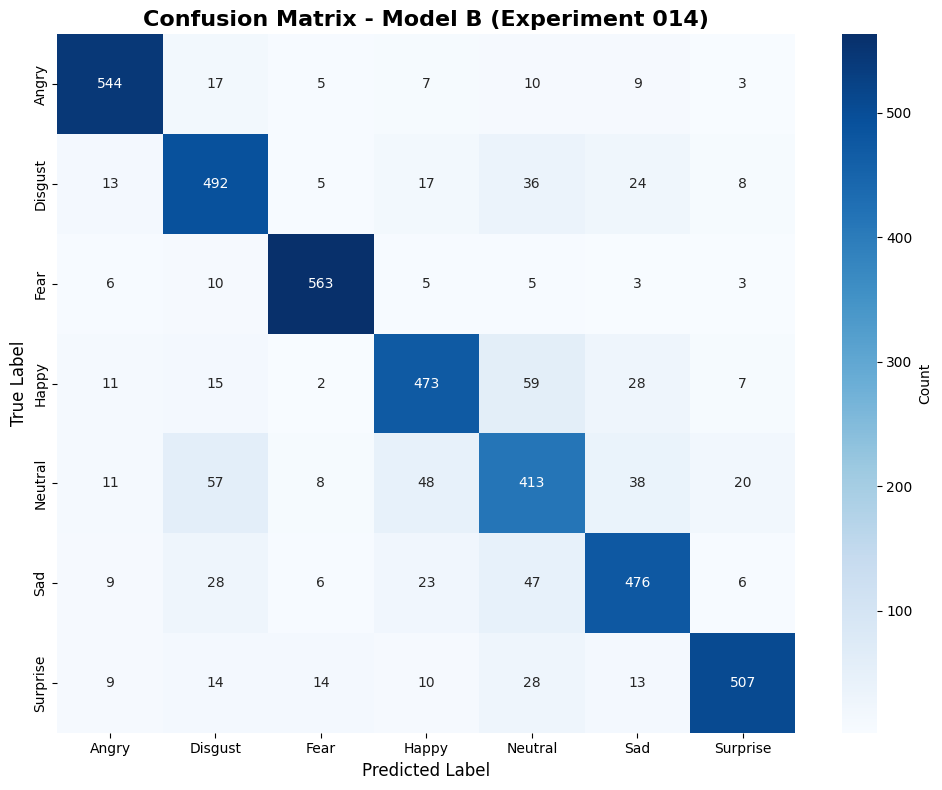

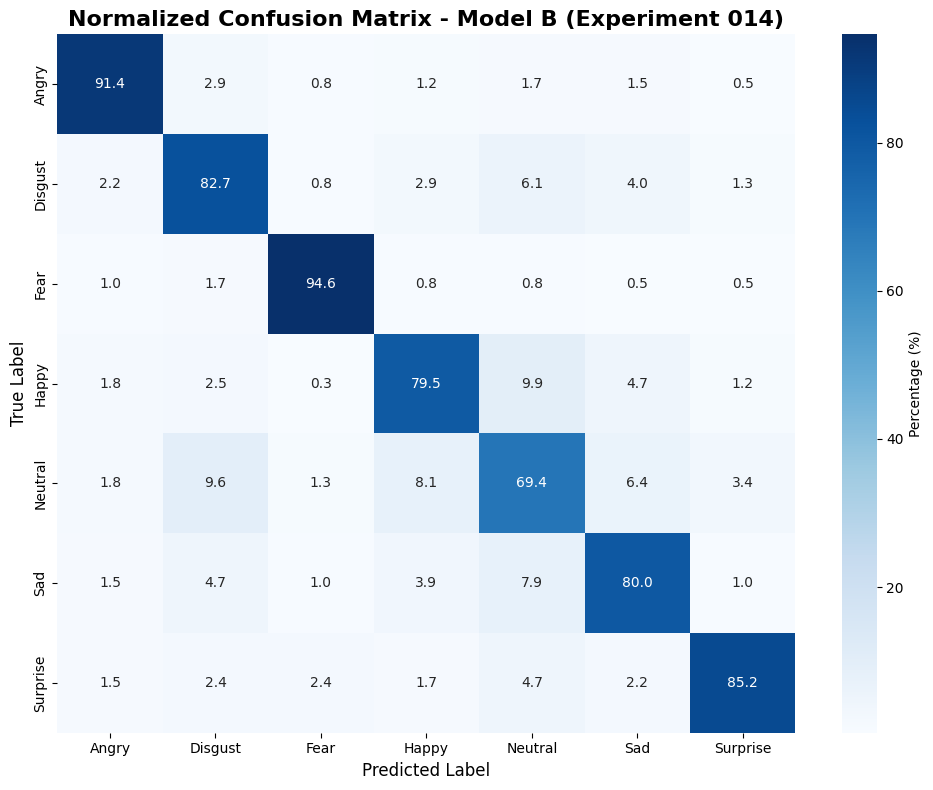

CONFUSION MATRIX SUMMARY
Total test samples: 4165

Per-class accuracy (diagonal / row sum):
  Angry       :  544/ 595 = 91.43%
  Disgust     :  492/ 595 = 82.69%
  Fear        :  563/ 595 = 94.62%
  Happy       :  473/ 595 = 79.50%
  Neutral     :  413/ 595 = 69.41%
  Sad         :  476/ 595 = 80.00%
  Surprise    :  507/ 595 = 85.21%

Most common misclassifications:
  Disgust      → Neutral     :  36 ( 6.05%)
  Happy        → Neutral     :  59 ( 9.92%)
  Neutral      → Disgust     :  57 ( 9.58%)
  Neutral      → Happy       :  48 ( 8.07%)
  Neutral      → Sad         :  38 ( 6.39%)
  Sad          → Neutral     :  47 ( 7.90%)


FileNotFoundError: [Errno 2] No such file or directory: 'ModelB/training_loss_chart.png'

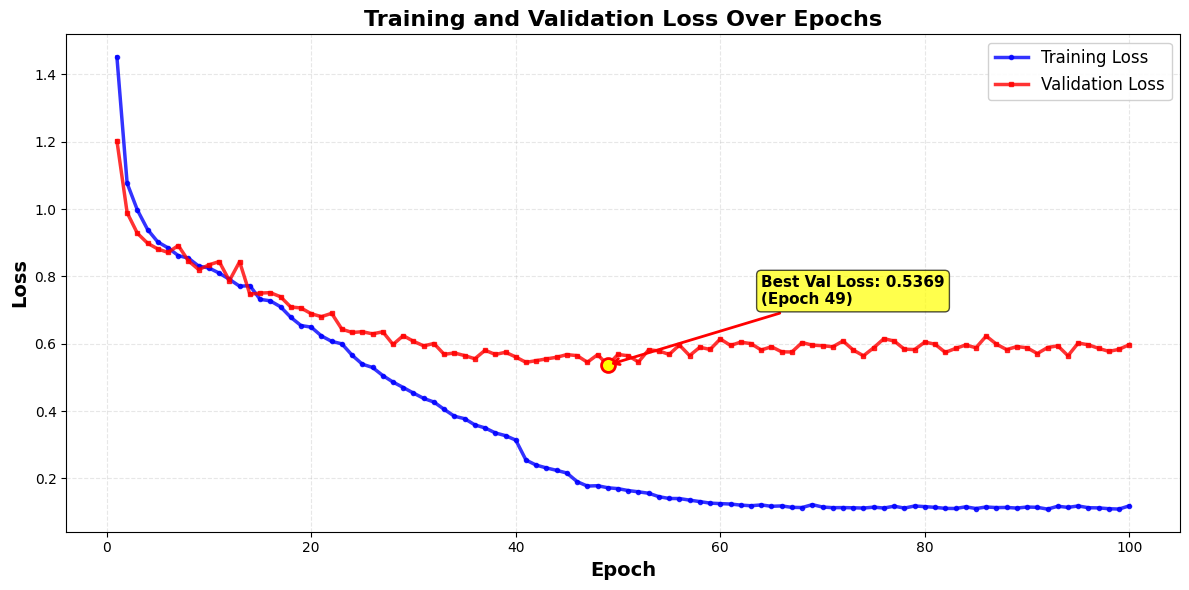

In [17]:
# Final Test Evaluation
# ⚠️ ONLY RUN THIS AFTER TRAINING HAS COMPLETED
# This evaluates on the TEST set (unseen data) for final unbiased results

from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support, f1_score
import csv
global EXPERIMENT_ID
# ============================================================================
# EXPERIMENT ID - FROM CONFIGURATION SECTION
# ============================================================================
# Uses EXPERIMENT_ID from the Configuration section and formats as 3-digit string
TEST_EXPERIMENT_ID = f"{EXPERIMENT_ID:03d}"  # Format as "001", "002", etc.
# ============================================================================

print("=" * 70)
print("FINAL TEST EVALUATION")
print("=" * 70)
print(f"Experiment ID: {TEST_EXPERIMENT_ID}")
print("Evaluating on TEST set (unseen data, never used during training)...")
print()

# Evaluate on test set - get predictions and labels
model_multi_b.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, text_tokens, labels in tqdm(loader_mm_test, desc='Testing'):
        images = images.to(device)
        text_tokens = text_tokens.to(device)
        labels = labels.to(device)
        
        logits, probabilities = model_multi_b(images, text_tokens)
        _, predicted = logits.max(1)
        
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Calculate overall metrics
test_acc = 100.0 * sum(p == l for p, l in zip(all_preds, all_labels)) / len(all_labels)
test_f1_macro = f1_score(all_labels, all_preds, average='macro', zero_division=0)

# Calculate per-class metrics (P, R, F1 for each class) - similar to VQA paper
precision, recall, f1, support = precision_recall_fscore_support(
    all_labels, all_preds, average=None, zero_division=0
)

# Calculate macro-averaged metrics (mean across all 7 classes)
# This gives a single summary metric for each: mean Precision, mean Recall, mean F1
from sklearn.metrics import precision_score, recall_score
test_precision_macro = precision_score(all_labels, all_preds, average='macro', zero_division=0)
test_recall_macro = recall_score(all_labels, all_preds, average='macro', zero_division=0)

# Get training/validation accuracies from training (if available)
# These will be None if loading from checkpoint without training
validation_accuracies = globals().get('validation_accuracies', None)
training_accuracies = globals().get('training_accuracies', None)

best_val_acc = max(validation_accuracies) if validation_accuracies and len(validation_accuracies) > 0 else None
final_val_acc = validation_accuracies[-1] if validation_accuracies and len(validation_accuracies) > 0 else None
final_train_acc = training_accuracies[-1] if training_accuracies and len(training_accuracies) > 0 else None

# Get emotion names in order (0-6) - used for both printing and CSV
emotion_names = [label_dict[i] for i in range(NUM_CLASSES)]

# Print results
print("=" * 70)
print("FINAL TEST RESULTS")
print("=" * 70)
print(f"Test Accuracy:      {test_acc:.2f}%")
print(f"Macro-Precision:     {test_precision_macro:.4f}  (mean across 7 classes)")
print(f"Macro-Recall:        {test_recall_macro:.4f}  (mean across 7 classes)")
print(f"Macro-F1:            {test_f1_macro:.4f}  (mean across 7 classes)")
print()
print("Training Metrics:")
if final_train_acc:
    print(f"  Final Train Acc:   {final_train_acc:.2f}%")
if final_val_acc:
    print(f"  Final Val Acc:     {final_val_acc:.2f}%")
if best_val_acc:
    print(f"  Best Val Acc:      {best_val_acc:.2f}%")
print("=" * 70)
print()

# Print per-class metrics (similar to VQA paper's per-class reporting)
# Note: VQA paper reports P, R, F1 per class - we do the same for emotion classes
print("PER-CLASS METRICS (Precision, Recall, F1):")
print("=" * 70)
print(f"{'Class':<15} {'Precision':<12} {'Recall':<12} {'F1-Score':<12}")
print("-" * 70)
for i, (emotion, p, r, f) in enumerate(zip(emotion_names, precision, recall, f1)):
    print(f"{emotion:<15} {p:<12.4f} {r:<12.4f} {f:<12.4f}")
print("=" * 70)
print()

# Print classification report
print("DETAILED CLASSIFICATION REPORT:")
print("=" * 70)
print(classification_report(all_labels, all_preds, target_names=emotion_names, zero_division=0))
print("=" * 70)

# Save to CSV
# Use absolute path to ensure it saves in the correct location
import os
test_results_file = os.path.join(os.getcwd(), 'test_results.csv')
# Alternative: if you want it in the same directory as the notebook:
# test_results_file = os.path.join(os.path.dirname(os.path.abspath('__file__')), 'test_results.csv')
print(f"Saving test results to: {test_results_file}")
test_results = {
    'Experiment_ID': TEST_EXPERIMENT_ID,  # Use the configurable experiment ID
    
    # Test Metrics
    'Test_Accuracy': f'{test_acc:.2f}%',
    'Macro_Precision': f'{test_precision_macro:.4f}',
    'Macro_Recall': f'{test_recall_macro:.4f}',
    'Macro_F1': f'{test_f1_macro:.4f}',
    
    # Training Metrics
    'Final_Train_Accuracy': f'{final_train_acc:.2f}%' if final_train_acc else '',
    'Final_Val_Accuracy': f'{final_val_acc:.2f}%' if final_val_acc else '',
    'Best_Val_Accuracy': f'{best_val_acc:.2f}%' if best_val_acc else '',
    
    # Hyperparameters (all configurable parameters)
    'Cross_Attention': 'On' if USE_CROSS_ATTENTION else 'Off',
    'Dropout': DROPOUT_P,
    'Learning_Rate': LEARNING_RATE,
    'Epochs': NUMBER_OF_EPOCHS,
    'Batch_Size': BATCH_SIZE,
    'Transformer_Layers': TRANSFORMER_NUM_LAYERS,
    'Transformer_Heads': TRANSFORMER_NHEAD,
    'Optimizer': OPTIMIZER_TYPE,
    'Data_Augmentation': USE_TRANSFORM,
}

# Add per-class metrics (P, R, F1 for each emotion class)
for i, emotion in enumerate(emotion_names):
    test_results[f'{emotion}_F1'] = f'{f1[i]:.4f}'
    test_results[f'{emotion}_Precision'] = f'{precision[i]:.4f}'
    test_results[f'{emotion}_Recall'] = f'{recall[i]:.4f}'

# Write to CSV
file_exists = os.path.exists(test_results_file)
with open(test_results_file, 'a', newline='') as csvfile:
    fieldnames = list(test_results.keys())
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
    
    if not file_exists:
        writer.writeheader()
    
    writer.writerow(test_results)

print(f"\n✓ Test results saved to {test_results_file}")
print(f"   File exists: {os.path.exists(test_results_file)}")
print(f"   File size: {os.path.getsize(test_results_file) if os.path.exists(test_results_file) else 0} bytes")
print()
print("=" * 70)
print("COMPARISON WITH VQA PAPER METRICS:")
print("=" * 70)
print("VQA Paper uses:")
print("  - VQA Accuracy (task accuracy) → Our: Test Accuracy")
print("  - Per-class P, R, F1 → Our: Per-emotion Precision, Recall, F1")
print("  - Macro-averaged metrics → Our: Macro-Precision, Macro-Recall, Macro-F1")
print("    (Mean across all 7 emotion classes)")
print()
print("Note: VQA paper also has grounding metrics (Overlap, IOU, Pointing Game)")
print("      which don't apply to emotion classification (no bounding boxes).")
print("=" * 70)
print()
print("Note: Test accuracy is your final unbiased performance metric.")
print("Validation accuracy was used during training for monitoring/tuning.")


### Confusion Matrix Visualization

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix

# Create confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Get emotion names in order
emotion_names = [label_dict[i] for i in range(NUM_CLASSES)]

# Create figure
plt.figure(figsize=(10, 8))

# Plot confusion matrix with seaborn for better visualization
sns.heatmap(cm, 
            annot=True, 
            fmt='d', 
            cmap='Blues',
            xticklabels=emotion_names,
            yticklabels=emotion_names,
            cbar_kws={'label': 'Count'})

plt.title('Confusion Matrix - Model B (Experiment 014)', fontsize=16, fontweight='bold')
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.tight_layout()
plt.show()

# Print normalized confusion matrix (percentages)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

plt.figure(figsize=(10, 8))
sns.heatmap(cm_normalized, 
            annot=True, 
            fmt='.1f', 
            cmap='Blues',
            xticklabels=emotion_names,
            yticklabels=emotion_names,
            cbar_kws={'label': 'Percentage (%)'})

plt.title('Normalized Confusion Matrix - Model B (Experiment 014)', fontsize=16, fontweight='bold')
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.tight_layout()
plt.show()

# Print summary statistics
print("=" * 70)
print("CONFUSION MATRIX SUMMARY")
print("=" * 70)
print(f"Total test samples: {len(all_labels)}")
print(f"\nPer-class accuracy (diagonal / row sum):")
for i, emotion in enumerate(emotion_names):
    class_total = cm[i].sum()
    class_correct = cm[i, i]
    class_acc = (class_correct / class_total * 100) if class_total > 0 else 0
    print(f"  {emotion:<12}: {class_correct:4d}/{class_total:4d} = {class_acc:5.2f}%")

print("\nMost common misclassifications:")
for i in range(NUM_CLASSES):
    for j in range(NUM_CLASSES):
        if i != j and cm[i, j] > 0:
            percentage = (cm[i, j] / cm[i].sum() * 100)
            if percentage > 5:  # Only show if > 5% of class
                print(f"  {emotion_names[i]:<12} → {emotion_names[j]:<12}: {cm[i, j]:3d} ({percentage:5.2f}%)")
print("=" * 70)


# ============================================================================
# TRAINING LOSS CHART - Add this cell to your notebook after training
# ============================================================================
# ⚠️ NOTE: This section only works if you trained the model (Option A).
# If you loaded from a checkpoint (Option B), training_losses and validation_losses
# will not be available, and this section will be skipped.

import matplotlib.pyplot as plt
import numpy as np

# Check if training metrics are available (only if training was run)
training_losses = globals().get('training_losses', None)
validation_losses = globals().get('validation_losses', None)

if training_losses is None or validation_losses is None or len(training_losses) == 0:
    print("=" * 70)
    print("TRAINING LOSS CHART - SKIPPED")
    print("=" * 70)
    print("⚠️ Training metrics (training_losses, validation_losses) are not available.")
    print("   This section only works after training a model (Option A).")
    print("   If you loaded from a checkpoint (Option B), training metrics are not saved.")
    print("   To generate training curves, you need to train a new model.")
    print("=" * 70)
else:
    # Make sure training_losses and validation_losses are available from training
    epochs = np.arange(1, len(training_losses) + 1)

    # Create the plot
    plt.figure(figsize=(12, 6))

    # Plot loss curves
    plt.plot(epochs, training_losses, 'b-', label='Training Loss', 
             linewidth=2.5, alpha=0.8, marker='o', markersize=3)
    plt.plot(epochs, validation_losses, 'r-', label='Validation Loss', 
             linewidth=2.5, alpha=0.8, marker='s', markersize=3)

    # Formatting
    plt.xlabel('Epoch', fontsize=14, fontweight='bold')
    plt.ylabel('Loss', fontsize=14, fontweight='bold')
    plt.title('Training and Validation Loss Over Epochs', fontsize=16, fontweight='bold')
    plt.legend(fontsize=12, framealpha=0.9)
    plt.grid(True, alpha=0.3, linestyle='--')

    # Find and mark best validation loss
    best_val_idx = np.argmin(validation_losses)
    best_val_epoch = epochs[best_val_idx]
    best_val_loss = validation_losses[best_val_idx]

    plt.plot(best_val_epoch, best_val_loss, 'ro', markersize=10, 
             markerfacecolor='yellow', markeredgecolor='red', markeredgewidth=2)

    # Add annotation
    plt.annotate(f'Best Val Loss: {best_val_loss:.4f}\n(Epoch {best_val_epoch})',
                xy=(best_val_epoch, best_val_loss),
                xytext=(best_val_epoch + len(epochs)*0.15, best_val_loss + max(validation_losses)*0.15),
                arrowprops=dict(arrowstyle='->', color='red', lw=2),
                fontsize=11, fontweight='bold',
                bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.7))

    plt.tight_layout()
    plt.savefig('ModelB/training_loss_chart.png', dpi=300, bbox_inches='tight')
    plt.show()

    print(f"Best validation loss: {best_val_loss:.4f} at epoch {best_val_epoch}")
    print(f"Final training loss: {training_losses[-1]:.4f}")
    print(f"Final validation loss: {validation_losses[-1]:.4f}")


## Save Trained Checkpoint

In [ ]:
# Save trained Model B checkpoint (controlled by SAVE_MODEL flag)

import os

if SAVE_MODEL:
    os.makedirs(CHECKPOINT_DIR, exist_ok=True)
    checkpoint_path = os.path.join(CHECKPOINT_DIR, CHECKPOINT_NAME)
    torch.save(model_multi_b.state_dict(), checkpoint_path)
    print(f"Saved Model B checkpoint to: {checkpoint_path}")
else:
    print("Skipping model save because SAVE_MODEL is set to False.")

## Load Saved Model (Option B: Use Existing Checkpoint)

**⚠️ Only run this section if you want to load a previously trained checkpoint.**

### Required Sections to Run FIRST (before this cell):

You **MUST** run these sections in order before loading a checkpoint:

1. **SETUP & CONFIGURATION** (Section 1)
   - Configuration cell (sets EXPERIMENT_ID, NUM_CLASSES, DROPOUT_P, etc.)
   - Imports cell

2. **DATA PREPARATION** (Section 2) 
   - Text processing cell (creates tokenizer and get_vocab_size function)
   - You can skip the actual data loading if you only want to load the model

3. **MODEL ARCHITECTURE** (Section 3)
   - Transformer Encoder class definition
   - MultiModalEmotionClassifierB class definition  
   - Model creation cell (creates `model_multi_b`)

### Then run this cell to load the checkpoint.

**Skip these sections:**
- ❌ Training Setup
- ❌ Training Loop  
- ❌ Save Trained Checkpoint

**If you want to train a new model instead, go back to "Training Loop (Option A)" above.**

In [ ]:
### Load Saved Model Checkpoint (Option B: Use Existing Checkpoint)

# ⚠️ IMPORTANT: Only run this if you want to load a saved checkpoint
# If you want to train a new model, go back to "Training Loop (Option A)" above
# and SKIP this entire section.
#
# Before running:
# 1. Make sure you have SKIPPED the "Training Setup" and "Training Loop" sections
# 2. Set EXPERIMENT_ID in Configuration to match the checkpoint you want to load
# 3. Ensure the checkpoint file exists in checkpoints/ directory

import os
import torch
global EXPERIMENT_ID

# Configuration - make sure EXPERIMENT_ID matches the checkpoint you want to load
LOAD_CHECKPOINT = True  # Set to False if you want to use freshly initialized model
CHECKPOINT_DIR = "checkpoints"
CHECKPOINT_NAME = f"modelB_exp{EXPERIMENT_ID:03d}.pth"  # e.g., modelB_exp014.pth
checkpoint_path = os.path.join(CHECKPOINT_DIR, CHECKPOINT_NAME)

if LOAD_CHECKPOINT and os.path.exists(checkpoint_path):
    print("=" * 70)
    print("LOADING SAVED MODEL CHECKPOINT")
    print("=" * 70)
    print(f"Loading from: {checkpoint_path}")
    
    # Make sure model is initialized first (run model creation cell if needed)
    # Then load the weights
    model_multi_b.load_state_dict(torch.load(checkpoint_path, map_location=device))
    model_multi_b.eval()
    model_multi_b.to(device)
    
    print(f"✓ Model loaded successfully!")
    print(f"  Checkpoint: {checkpoint_path}")
    print(f"  Model on device: {device}")
    print("=" * 70)
    
    # Optional: Verify by checking a quick test
    print("\nVerifying model is loaded correctly...")
    # You can add a quick sanity check here if desired
    
elif LOAD_CHECKPOINT:
    print("=" * 70)
    print("WARNING: CHECKPOINT NOT FOUND")
    print("=" * 70)
    print(f"Looking for: {checkpoint_path}")
    print(f"File exists: {os.path.exists(checkpoint_path)}")
    print("\nAvailable checkpoints:")
    if os.path.exists(CHECKPOINT_DIR):
        checkpoints = [f for f in os.listdir(CHECKPOINT_DIR) if f.endswith('.pth')]
        for cp in checkpoints:
            print(f"  - {cp}")
    else:
        print(f"  Checkpoint directory '{CHECKPOINT_DIR}' does not exist.")
    print("\nUsing freshly initialized model (not trained).")
    print("=" * 70)
else:
    print("LOAD_CHECKPOINT is False - using current model state.")
    print("(This may be untrained if you cleared the notebook)")


    

# 5. DEMONSTRATIONS

### Helper: Single-Example Prediction (image + text)

In [19]:
### Enhanced Demo Helper Functions

from PIL import Image
import matplotlib.pyplot as plt
import torch.nn.functional as F

def predict_single(image_path, text, model=None, device=None, transform=None, max_length=None, show_image=True):
    """
    image_path: path to image file OR PIL Image object
    text: raw text string
    model: model_multi_b (if None, will use global model_multi_b)
    show_image: if True, displays the image inline
    """
    model = model or model_multi_b
    device = device or torch.device("cuda" if torch.cuda.is_available() else "cpu")
    transform = transform or transform_used
    max_length = max_length or MAX_TEXT_LENGTH

    model.eval()
    model.to(device)

    # ----- Image preprocessing -----
    if isinstance(image_path, str):
        img = Image.open(image_path).convert("RGB")
    else:
        img = image_path  # Assume it's already a PIL Image
    
    img_tensor = transform(img).unsqueeze(0).to(device)

    # ----- Text preprocessing -----
    text_tokens = tokenize_text(text, max_length=max_length)
    text_tokens = text_tokens.unsqueeze(0).to(device)

    # ----- Forward pass -----
    with torch.no_grad():
        logits, probabilities = model(img_tensor, text_tokens)
        probs = probabilities.squeeze(0).cpu().numpy()
        pred_idx = probs.argmax()
        pred_label = label_dict[int(pred_idx)]

    # Display image if requested
    if show_image:
        plt.figure(figsize=(6, 6))
        plt.imshow(img)
        plt.axis('off')
        plt.title(f"Predicted: {pred_label}\nText: {text[:50]}...", fontsize=12)
        plt.tight_layout()
        plt.show()

    # Pretty print
    print("=" * 70)
    print(f"Input text: {text}")
    print(f"Predicted emotion: {pred_label} (confidence: {probs[pred_idx]:.3f})")
    print("\nAll class probabilities:")
    for i, p in enumerate(probs):
        marker = " ←" if i == pred_idx else ""
        print(f"  {label_dict[i]:<12}: {p:.3f}{marker}")
    print("=" * 70)

    return pred_label, probs

def test_from_dataset(dataset, model, device, num_examples=3, random_seed=42):
    """
    Sample examples from test set and show predictions vs ground truth
    """
    import random
    random.seed(random_seed)
    np.random.seed(random_seed)
    
    model.eval()
    model.to(device)
    
    # Get random indices
    indices = random.sample(range(len(dataset)), min(num_examples, len(dataset)))
    
    print(f"\n{'='*70}")
    print(f"TEST SET DEMONSTRATION - {num_examples} Examples")
    print(f"{'='*70}\n")
    
    for idx, sample_idx in enumerate(indices, 1):
        # Get sample from dataset
        image, text_tokens, true_label = dataset[sample_idx]
        
        # Get original image (before transform) - we need to get it from ImageFolder
        # Since dataset uses ImageFolder, we can access the original image path
        img_path = dataset.data_image.imgs[sample_idx][0]  # (path, label)
        original_img = Image.open(img_path).convert("RGB")
        
        # Get text from dataframe
        text_row = dataset.text_dataframe.iloc[sample_idx]
        text = text_row['text']
        true_emotion = label_dict[int(true_label)]
        
        # Make prediction
        image_tensor = transform_used(original_img).unsqueeze(0).to(device)
        text_tokens_batch = text_tokens.unsqueeze(0).to(device)
        
        with torch.no_grad():
            logits, probabilities = model(image_tensor, text_tokens_batch)
            probs = probabilities.squeeze(0).cpu().numpy()
            pred_idx = probs.argmax()
            pred_emotion = label_dict[int(pred_idx)]
        
        # Display
        print(f"\nExample {idx}:")
        print(f"  Image: {img_path.split('/')[-1]}")
        print(f"  Ground Truth: {true_emotion}")
        print(f"  Predicted: {pred_emotion} {'✓' if pred_emotion == true_emotion else '✗'}")
        print(f"  Confidence: {probs[pred_idx]:.3f}")
        
        # Show image
        plt.figure(figsize=(8, 4))
        plt.subplot(1, 2, 1)
        plt.imshow(original_img)
        plt.axis('off')
        plt.title(f"Image\nTrue: {true_emotion}", fontsize=10)
        
        plt.subplot(1, 2, 2)
        emotions = [label_dict[i] for i in range(NUM_CLASSES)]
        colors = ['green' if e == pred_emotion else 'lightblue' for e in emotions]
        plt.barh(emotions, probs, color=colors)
        plt.xlabel('Probability')
        plt.title(f'Predictions\nPredicted: {pred_emotion}', fontsize=10)
        plt.tight_layout()
        plt.show()
        
        print("-" * 70)


def test_from_custom(custom_examples, model=None, device=None, transform=None, max_length=None):
    """
    Test on custom images with text - similar format to test_from_dataset
    custom_examples: list of tuples [(image_path, text), (image_path, text), ...]
    """
    model = model or model_multi_b
    device = device or torch.device("cuda" if torch.cuda.is_available() else "cpu")
    transform = transform or transform_used
    max_length = max_length or MAX_TEXT_LENGTH
    
    model.eval()
    model.to(device)
    
    print(f"\n{'='*70}")
    print(f"CUSTOM IMAGES DEMONSTRATION - {len(custom_examples)} Examples")
    print(f"{'='*70}\n")
    
    for idx, (image_path, text) in enumerate(custom_examples, 1):
        # Load image
        img = Image.open(image_path).convert("RGB")
        
        # Preprocess
        img_tensor = transform(img).unsqueeze(0).to(device)
        text_tokens = tokenize_text(text, max_length=max_length).unsqueeze(0).to(device)
        
        # Make prediction
        with torch.no_grad():
            logits, probabilities = model(img_tensor, text_tokens)
            probs = probabilities.squeeze(0).cpu().numpy()
            pred_idx = probs.argmax()
            pred_emotion = label_dict[int(pred_idx)]
        
        # Display
        print(f"\nExample {idx}:")
        print(f"  Image: {image_path.split('/')[-1]}")
        print(f"  Predicted: {pred_emotion}")
        print(f"  Confidence: {probs[pred_idx]:.3f}")
        
        # Show image with probability chart (same format as test_from_dataset)
        plt.figure(figsize=(8, 4))
        plt.subplot(1, 2, 1)
        plt.imshow(img)
        plt.axis('off')
        plt.title(f"Image\nPredicted: {pred_emotion}", fontsize=10)
        
        plt.subplot(1, 2, 2)
        emotions = [label_dict[i] for i in range(NUM_CLASSES)]
        colors = ['green' if e == pred_emotion else 'lightblue' for e in emotions]
        plt.barh(emotions, probs, color=colors)
        plt.xlabel('Probability')
        plt.title(f'Predictions\nPredicted: {pred_emotion}', fontsize=10)
        plt.tight_layout()
        plt.show()
        
        print("-" * 70)

## DEMO 1: Test Set Examples

Random seed: 6616

TEST SET DEMONSTRATION - 5 Examples


Example 1:
  Image: aug_729049.png
  Ground Truth: Surprise
  Predicted: Surprise ✓
  Confidence: 1.000


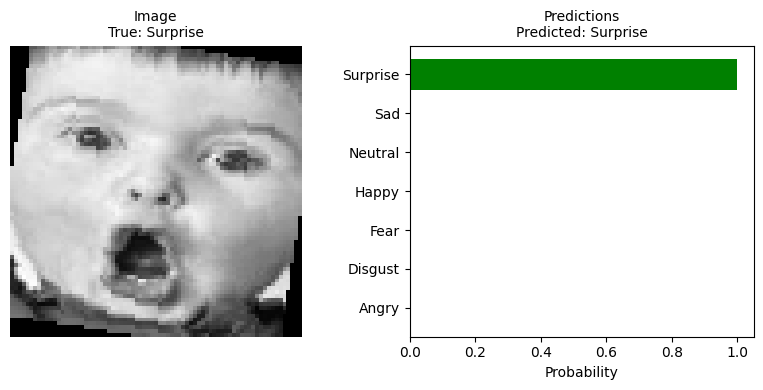

----------------------------------------------------------------------

Example 2:
  Image: aug_365332.png
  Ground Truth: Fear
  Predicted: Fear ✓
  Confidence: 1.000


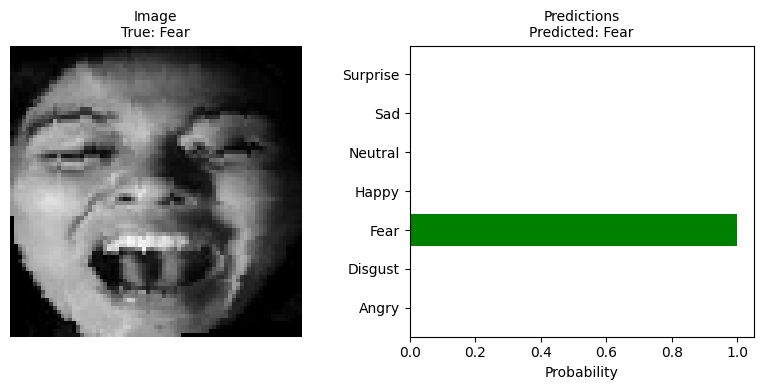

----------------------------------------------------------------------

Example 3:
  Image: train_10668_aligned.jpg
  Ground Truth: Neutral
  Predicted: Happy ✗
  Confidence: 0.955


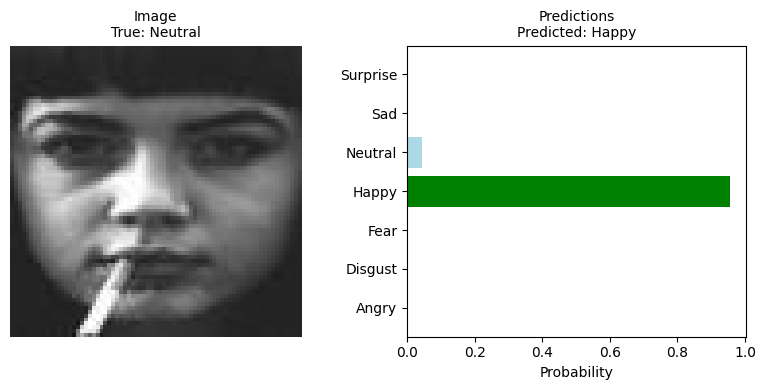

----------------------------------------------------------------------

Example 4:
  Image: aug_135613.png
  Ground Truth: Sad
  Predicted: Sad ✓
  Confidence: 0.482


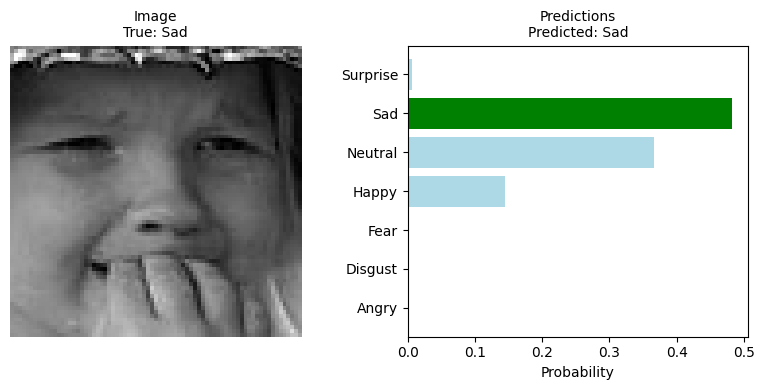

----------------------------------------------------------------------

Example 5:
  Image: aug_267643.png
  Ground Truth: Angry
  Predicted: Angry ✓
  Confidence: 1.000


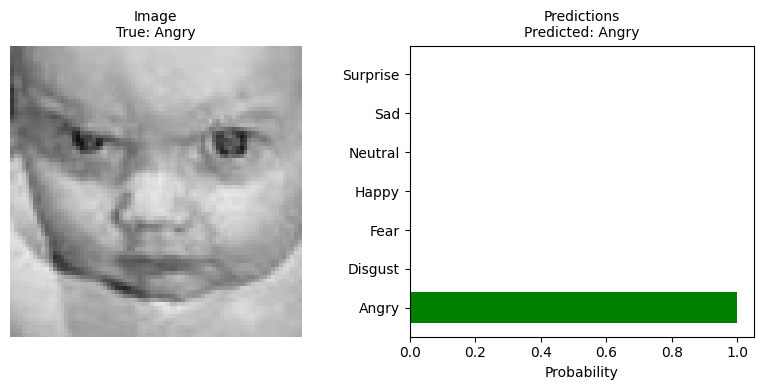

----------------------------------------------------------------------


In [20]:
### Demo 1: Test Set Examples (with Ground Truth)

import random
random_seed = random.randint(0, 10000)

# Sample 3 random examples from test set and show predictions
print(f"Random seed: {random_seed}")
test_from_dataset(
    dataset=dataset_mm_test,
    model=model_multi_b,
    device=device,
    num_examples=5,
    random_seed=random_seed  # Set seed for reproducibility
)

## DEMO 2: Custom Image/Text Test

In [ ]:
### Demo 2: Custom Image + Text Examples

example_1_path= "../test_pictures/abram_surprise_supercropped.png"
example_1_text= "I am surprised"

example_2_path= "../test_pictures/andrew_angry.png"
example_2_text= "I feel angry"

example_3_path= "../test_pictures/ava_sad_cropped.png"
example_3_text= "I am feeling sad."

custom_examples = [
    (example_1_path, example_1_text),
    (example_2_path, example_2_text),
    (example_3_path, example_3_text)
]

# Run the demonstration
test_from_custom(
    custom_examples=custom_examples,
    model=model_multi_b,
    device=device
)